# Analysis of Restricted Boltzmann Machines (RBMs) and Autoencoders (AE)

In [1]:
import numpy as np
import pandas as pd
from project import rbm
from project import autoencoder
from project import data_retriever as dr
from project import nn_controller as nc
import math
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
# loading the data
x_train, y_train, x_valid, y_valid, x_test, y_test = dr.DataRetriever.get_data(data_folder='project/data')

In [3]:
# results path
rbm_results_path = 'project/results/rbm/'
ae_results_path = 'project/results/ae/'

### Helper Functions 

In [103]:
def plot_varying_hidden_units(trn_errors, vldn_errors, hidden_units):
    matplotlib.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(15, 27))
    start_plot = 411

    for i in range(len(hidden_units)):
        ax = fig.add_subplot(start_plot)
        x = np.arange(1, len(trn_errors[hidden_units[i]]) + 1)
        ax.plot(x, trn_errors[hidden_units[i]], label="training error")
        ax.plot(x, vldn_errors[hidden_units[i]], label="validation error")
        ax.set_title("%s Hidden Units" %(hidden_units[i]))
        ax.set_xlabel('Epochs')
        ax.set_ylabel('CE Reconstruction Error')
        ax.legend()
        start_plot +=1

plt.show()

In [104]:
def plot_single_error_graph(trn_error, vldn_error):
    matplotlib.rcParams.update({'font.size': 14})
    x = np.arange(1, len(trn_error)+1)
    plt.figure(figsize=(20, 5))
    plt.plot(x,trn_error,'r', label="training error")
    plt.plot(x,vldn_error,'b', label="validation error")
    plt.xlabel('Epochs')
    plt.ylabel('Cross entropy reconstruction error')
    plt.legend()
    plt.show()

In [105]:
def visualize_100_weights(w):
    w = w.T.reshape((-1,28,28))
    fig = plt.figure(figsize=(100, 100))
    for i in range(100):
        sub = fig.add_subplot(10,10, i + 1)
        sub.imshow(w[i], cmap=plt.cm.gray)

In [120]:
def plot_cd_k_graphs(lrn_rate):
    hdf_files = {}
    if lrn_rate == 0.01:
        hdf_files[5] = pd.HDFStore(rbm_results_path +'rbm_cd_5.hdf5')
        hdf_files[10] = pd.HDFStore(rbm_results_path +'rbm_cd_10.hdf5')
        hdf_files[20] = pd.HDFStore(rbm_results_path +'rbm_cd_20.hdf5')
    elif lrn_rate == 0.1:
        hdf_files[5] = pd.HDFStore(rbm_results_path +'rbm_cd2_5.hdf5')
        hdf_files[10] = pd.HDFStore(rbm_results_path +'rbm_cd2_10.hdf5')
        hdf_files[20] = pd.HDFStore(rbm_results_path +'rbm_cd2_20.hdf5')
    
 

    
    trn_err_5 = np.array(hdf_files[5]['trn_ce_recon_err'])
    vldn_err_5 = np.array(hdf_files[5]['vldn_ce_recon_err'])
    epochs_5 = np.arange(1, len(trn_err_5) + 1)
    
    trn_err_10 = hdf_files[10]['trn_ce_recon_err']
    vldn_err_10 = hdf_files[10]['vldn_ce_recon_err']
    epochs_10 = np.arange(1, len(trn_err_10) + 1)
    
    trn_err_20 = hdf_files[20]['trn_ce_recon_err']
    vldn_err_20 = hdf_files[20]['vldn_ce_recon_err']
    epochs_20 = np.arange(1, len(trn_err_20) + 1)
    
    
    matplotlib.rcParams.update({'font.size': 14})
    plt.figure(figsize=(15, 10))
    plt.plot(epochs_5, trn_err_5, label='k =5 trn err', linewidth=3)
    plt.plot(epochs_5, vldn_err_5, label='k =5 vldn err', linewidth=3)
    plt.plot(epochs_10, trn_err_10, label='k =10 trn err', linewidth=3)
    plt.plot(epochs_10, vldn_err_10, label='k =10 vldn err', linewidth=3)
    plt.plot(epochs_20, trn_err_20, label ='k =20 trn err', linewidth=3)
    plt.plot(epochs_20, vldn_err_20, label='k =20 vldn err', linewidth=3)
    plt.xlabel('Epochs')
    plt.ylabel('Cross entropy reconstruction error')
    plt.legend()
    plt.show()
    

## a) Basic generalization
RBM  was trained with:
- Hidden units: 100
- Mini batch size = 32
- CD - 'k' = 1
- Learning rate - 0.1
###### - Stopping criteria: When the difference between validation errors in 10 consecutive epochs is less than 0.1

In [14]:
#  train the model
rbm1 = rbm.RBM(h_count=100, 
               v_count=x_train.shape[1], 
               random_seed=2017, 
               results_file=rbm_results_path + 'rbm1.hdf5')

rbm1.train(trn_data=x_train, 
           vldn_data=x_valid, 
           mini_batch_size=32, 
           cd_k=1, 
           lrn_rate=0.1, 
           vldn_error_stopping_threshold=0.1, 
           vldn_error_checking_window=10, 
           suppress_output=True)

Total time taken to train = 515.677765131


#### 515 ticks is 8 minutes and 35 seconds.

### Plotting average cross-entropy reconstruction errors

Total number of training epochs = 838


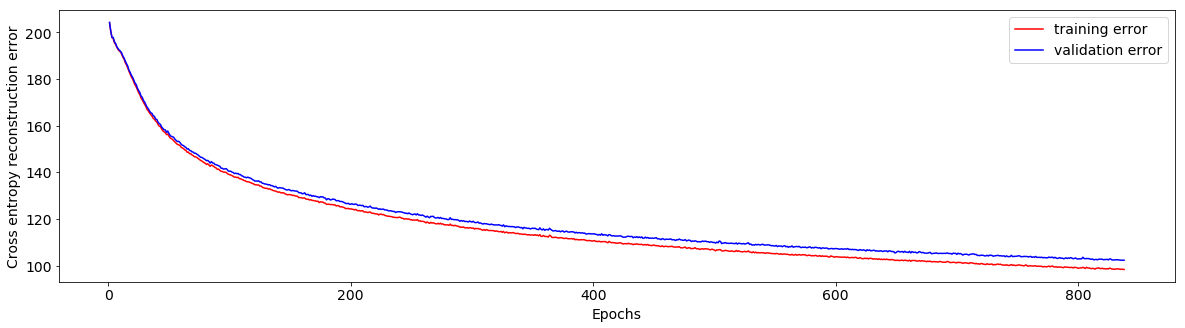

In [83]:
# obtaining the data
hdf = pd.HDFStore(rbm_results_path + 'rbm1.hdf5')
trn_err = np.asarray(hdf['trn_ce_recon_err'])
vldn_err = np.asarray(hdf['vldn_ce_recon_err'])
free_energy = np.asarray(hdf['free_energies_diff'])
print('Total number of training epochs = %s' %(len(trn_err)))

# plotting
plot_single_error_graph(trn_error=trn_err, vldn_error=vldn_err)


This trend is as expected: Training error falls more quickly than validation error.

### Difference in avg free energies
The absolute difference in average free energies between a  subset of size 100 of the training and the complete validation sets was calculated. The free energy difference increases, reaches a max around 100 epochs and falls from there on.  

From Geoff Hinton's manual 'A Practical Guide to Training Restricted Boltzmann Machines', overfitting starts when this difference begins to increase consistently, corresponding to a decrease in free energy of the training and increase in that of the validation set. Althought this difference fluctuates, its range is fairly constant from 600 - 800 epochs. This means that overfitting regime has not started even after 800 epochs. 

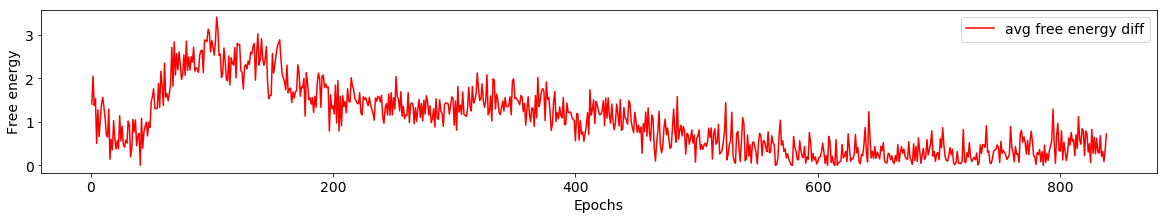

In [29]:
x = np.arange(1, len(trn_err)+1)
plt.figure(figsize=(20, 3))
plt.plot(x,free_energy[1:],'r', label="avg free energy diff")
plt.xlabel('Epochs')
plt.ylabel('Free energy')
plt.legend()
plt.show()

### Visualizing the weights
The weights do exhibit some very distinct structure

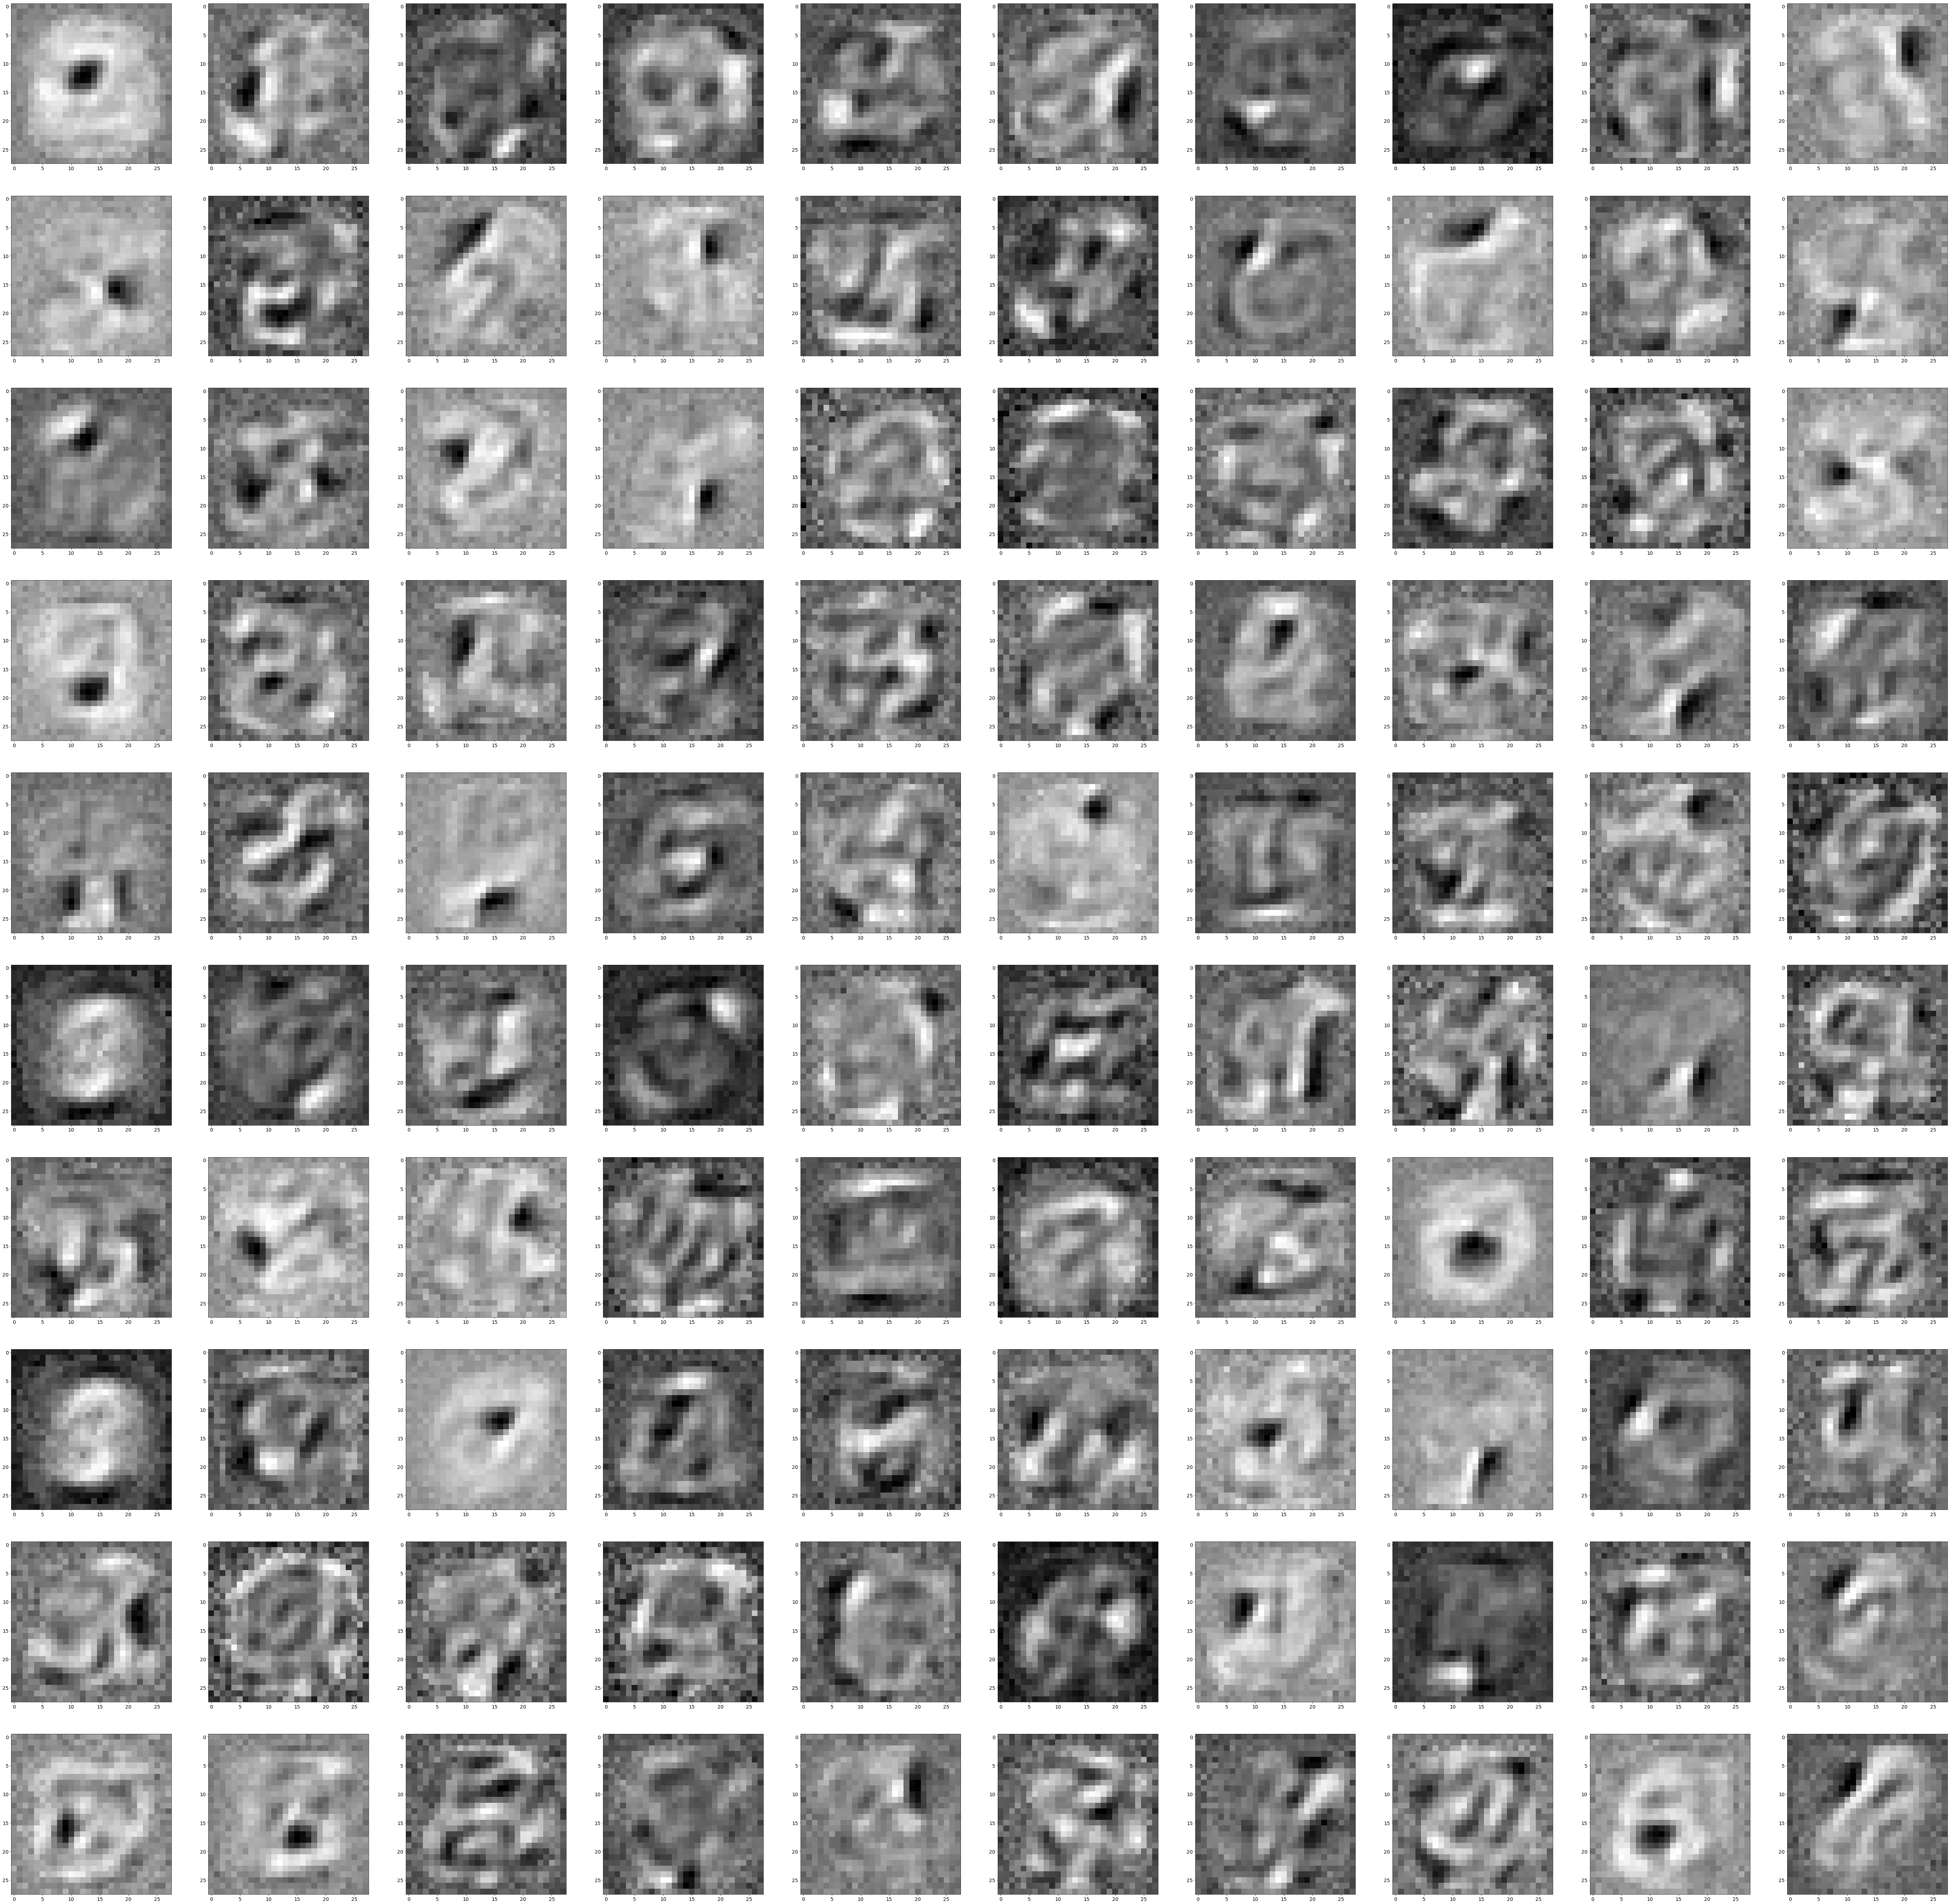

In [86]:
visualize_100_weights(np.asarray(hdf['w']))

## b) Varying number of CD steps
All hyper-parameters were kept same as the previous part including the random seed. Only the value of cd-k was changed.

#### This experiment was performed in 2 stages: with lrn rate 0.01 and then with lrn rate 0.1

In [ ]:
cds = [5, 10, 20]
for i in range(len(cds)):
    rbm1 = rbm.RBM(h_count=100, 
                   v_count=x_train.shape[1], 
                   random_seed=2017, 
                   results_file=rbm_results_path + 'rbm_cd2_' + str(cds[i])  + '.hdf5')

    rbm1.train(trn_data=x_train, 
               vldn_data=x_valid, 
               mini_batch_size=32, 
               cd_k=cds[i], 
               lrn_rate=0.1, 
               max_epochs=500,
               vldn_error_stopping_threshold=0.1, 
               vldn_error_checking_window=10, 
               suppress_output=False)

### Convergence of various k values when learning rate = 0.01

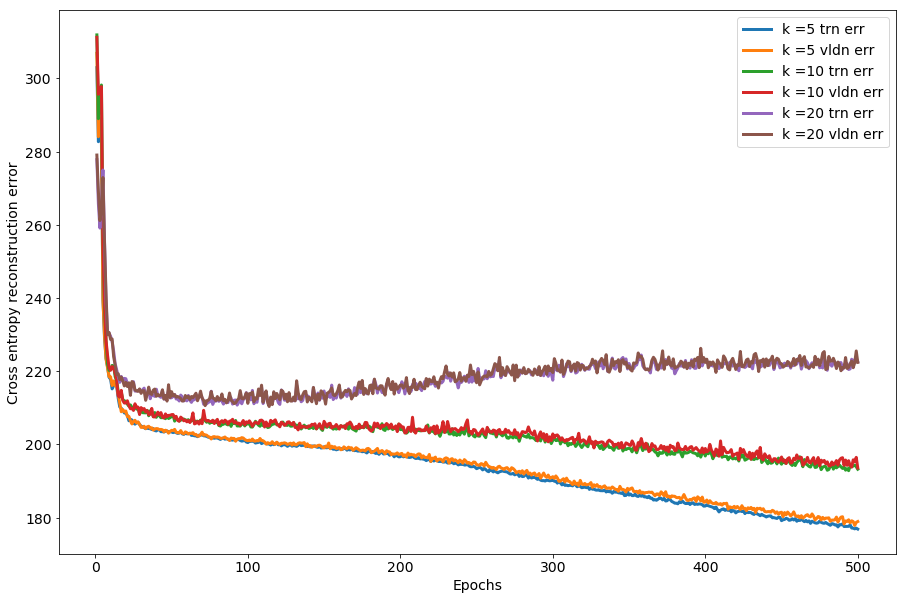

In [121]:
plot_cd_k_graphs(lrn_rate=0.01)

### Convergence of various k values when learning rate = 0.1

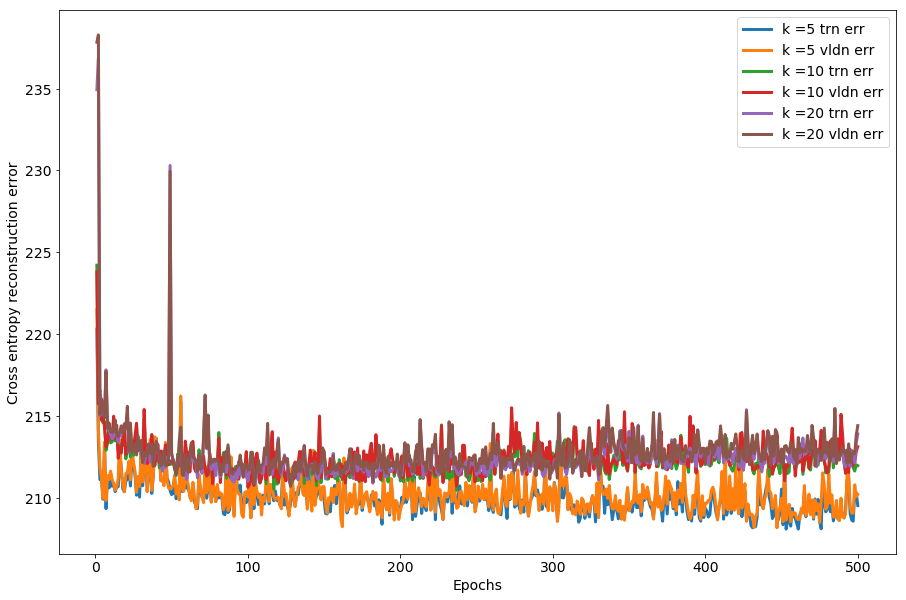

In [122]:
plot_cd_k_graphs(lrn_rate=0.1)

### Convergence:
- Lower k values reach lower error values in the same number of epochs and exhibit lower bouncing in the error rates. This is because there is lesser stochasticity in the gradient estimation for lower k values than higher k values.

### Generalization:
- Higher k values generalize better than lower ones.

## c) Sampling from this RBM
Images were sampled using the weights learned from part a with cd_k = 1. Some of the samples look like a 7, 6 etc.

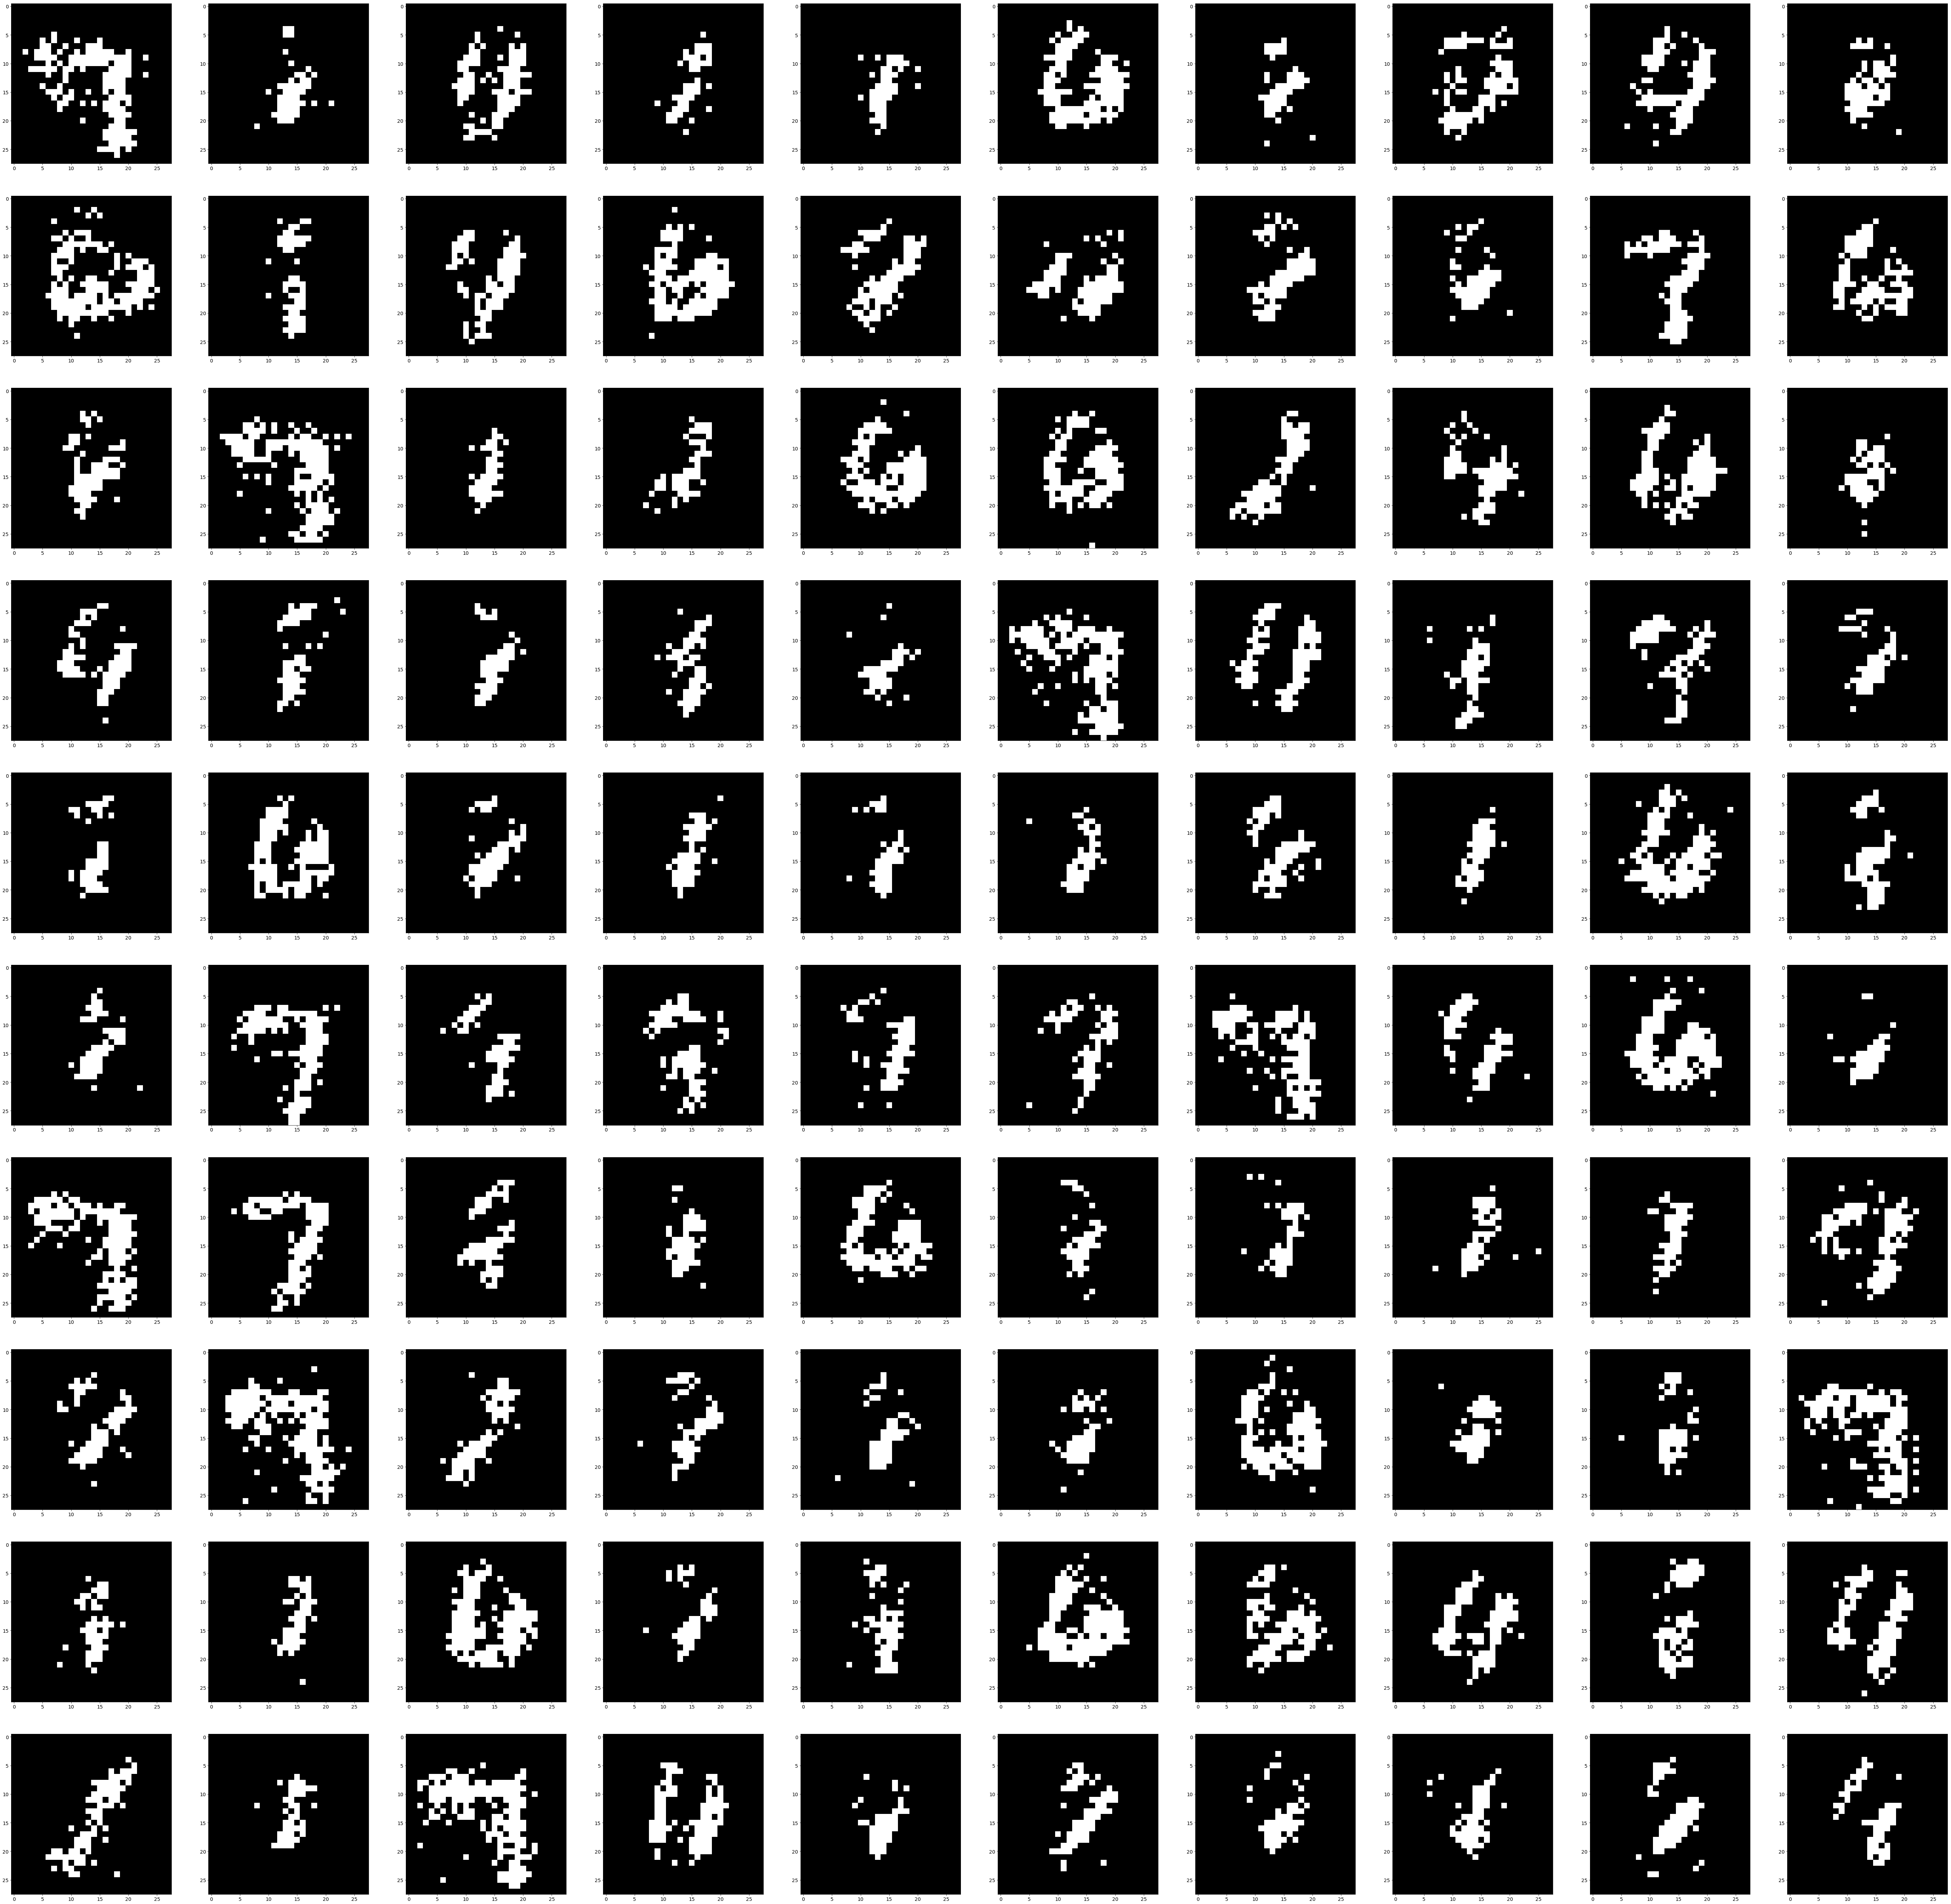

In [61]:
# Retrieving stored data
hdf3 = pd.HDFStore(rbm_results_path + 'rbm1.hdf5')
w3 = np.asarray(hdf3['w'])
h_bias3 = np.asarray(hdf3['h_bias'])
v_bias3 = np.asarray(hdf3['v_bias'])
rbm3 = rbm.RBM(h_count=100, v_count=784, random_seed=2017, results_file=None, w=w3, h_bias=h_bias3, v_bias=v_bias3)

# Performing 1000 steps of Gibbs sampling for 100 random inputs
v0 = np.random.randint(0,1,size=(100,784))
for i in range (1000):
    v1 = rbm3.vhv_gibbs_sample(v0_sample=v0)
    v0 = v1

# Plotting the image
fig = plt.figure(figsize=(100, 100))  # width, height in inches
v0 = v0.reshape(-1,28,28)
for i in range(100):
    sub = fig.add_subplot(10,10, i + 1)
    sub.imshow(v0[i], cmap=plt.cm.gray)


## d) Using random weights to initialize a NN - This is done at the very end of this section.

## e) Autoencoder 

In [72]:
from project import autoencoder
import time

ae = autoencoder.AE(h_count=100, v_count=x_train.shape[1], random_seed=2017, results_file=ae_results_path+'ae1.hdf5')
start_time = time.clock()
ae.train(trn_data=x_train, 
         vldn_data=x_valid, 
         mini_batch_size=32, 
         lrn_rate=0.001, 
         dropout=0, 
         vldn_error_stopping_threshold=0.05, 
         vldn_error_checking_window=10, 
         suppress_output=True)

print('Time taken = %s' % (time.clock() - start_time))

Time taken = 154.678436


### Plotting cross entropy reconstruction errors
The autoencoder takes less iterations and a much smaller learning rate (0.001) to converge than the RBM although all other hyper-parameters including the random seed are the same.

Total number of training epochs = 103


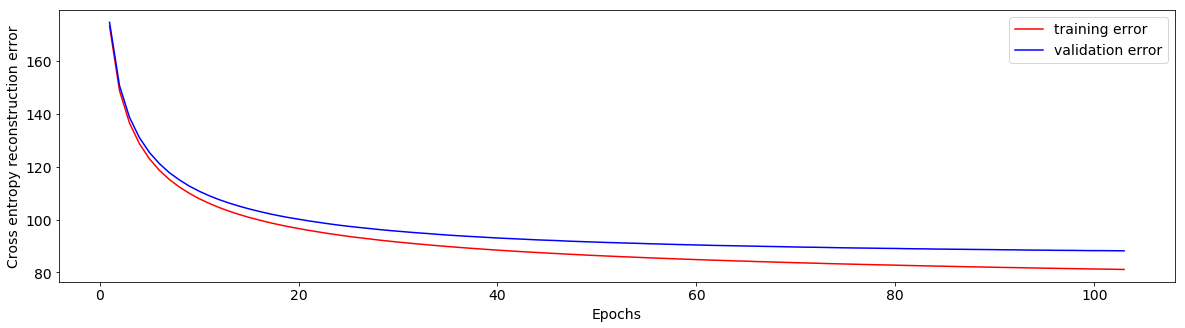

In [87]:
# obtaining the data
hdf = pd.HDFStore(ae_results_path+'ae1.hdf5')
trn_err = np.asarray(hdf['trn_ce_recon_err'])
vldn_err = np.asarray(hdf['vldn_ce_recon_err'])
print('Total number of training epochs = %s' %(len(trn_err)))

# plotting
plot_single_error_graph(trn_error=trn_err, vldn_error=vldn_err)

### Visualizing the weights
The weights learned by the autoencoder have a more distinct structure than those learned by the Restricted Boltzmann Machine. The borders and outlines of the filters are more distinct and intricate than those learned by the RBM.

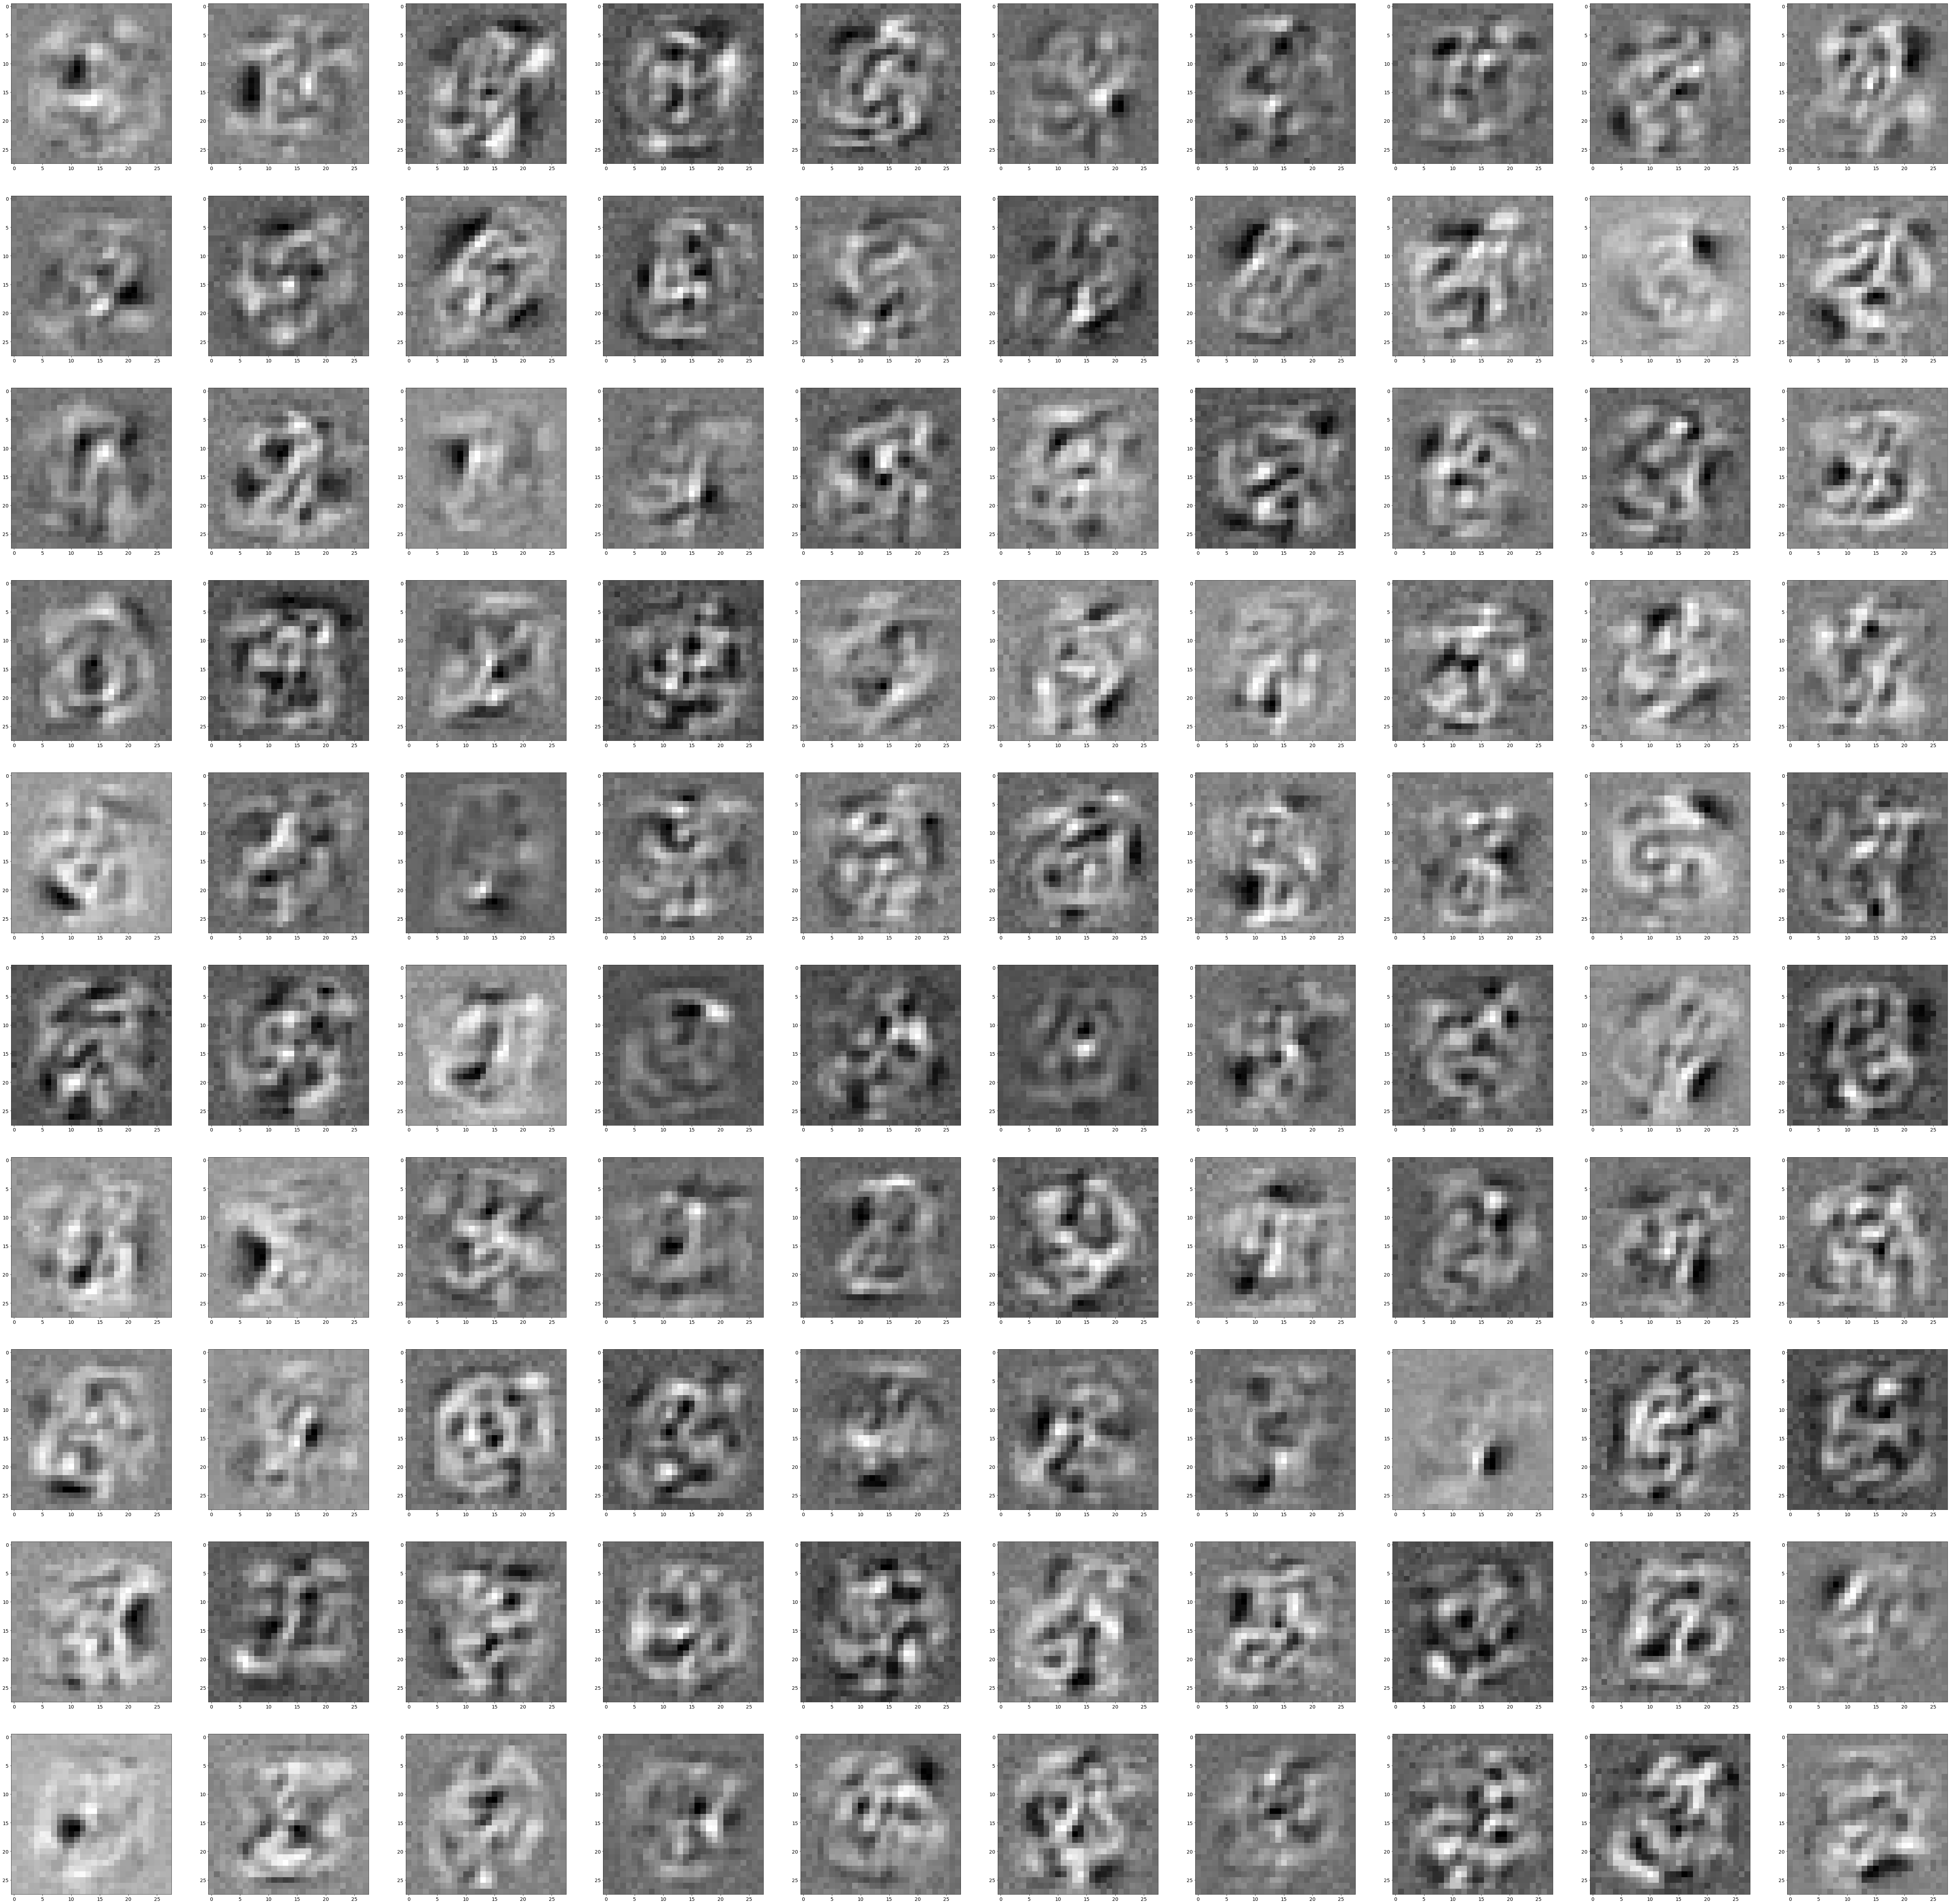

In [89]:
visualize_100_weights(np.asarray(hdf['w']))

### Note: The unsupervised pre-training of a NN using the Autoencoder's weights is done at the very end after part (g) 

## f) Denoising Autoencoder
With dropout of 10 %

In [77]:
ae1 = autoencoder.AE(h_count=100, v_count=x_train.shape[1], random_seed=2017, results_file=ae_results_path+'ae2.hdf5')
start_time = time.clock()
ae1.train(trn_data=x_train, 
         vldn_data=x_valid, 
         mini_batch_size=32, 
         lrn_rate=0.001, 
         dropout=0.1, # THIS IS THE ONLY DIFFERENCE FROM THE PREVIOUS AUTOENCODER 
         vldn_error_stopping_threshold=0.05, 
         vldn_error_checking_window=10, 
         suppress_output=True)

print('Time taken = %s' % (time.clock() - start_time))

Time taken = 367.807559


### Plotting cross entropy reconstruction errors

Total number of training epochs = 233


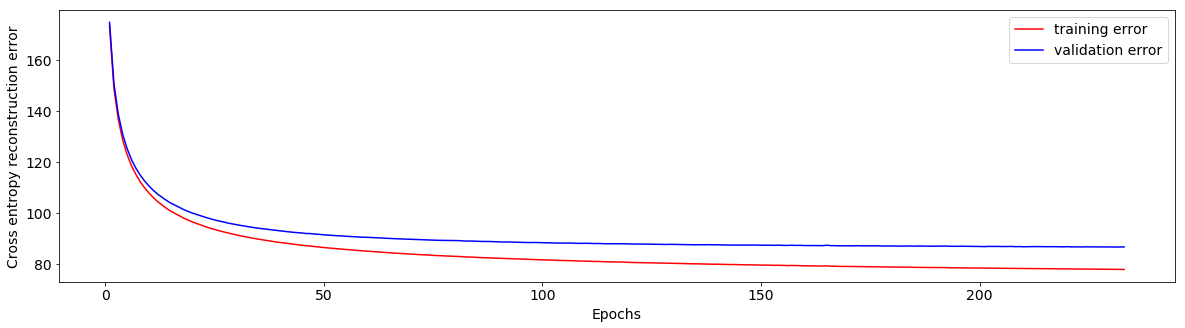

In [90]:
# obtaining the data
hdf1 = pd.HDFStore(ae_results_path+'ae2.hdf5')
trn_err = np.asarray(hdf1['trn_ce_recon_err'])
vldn_err = np.asarray(hdf1['vldn_ce_recon_err'])
print('Total number of training epochs = %s' %(len(trn_err)))

# plotting
plot_single_error_graph(trn_error=trn_err, vldn_error=vldn_err)

### Visualizing the weights

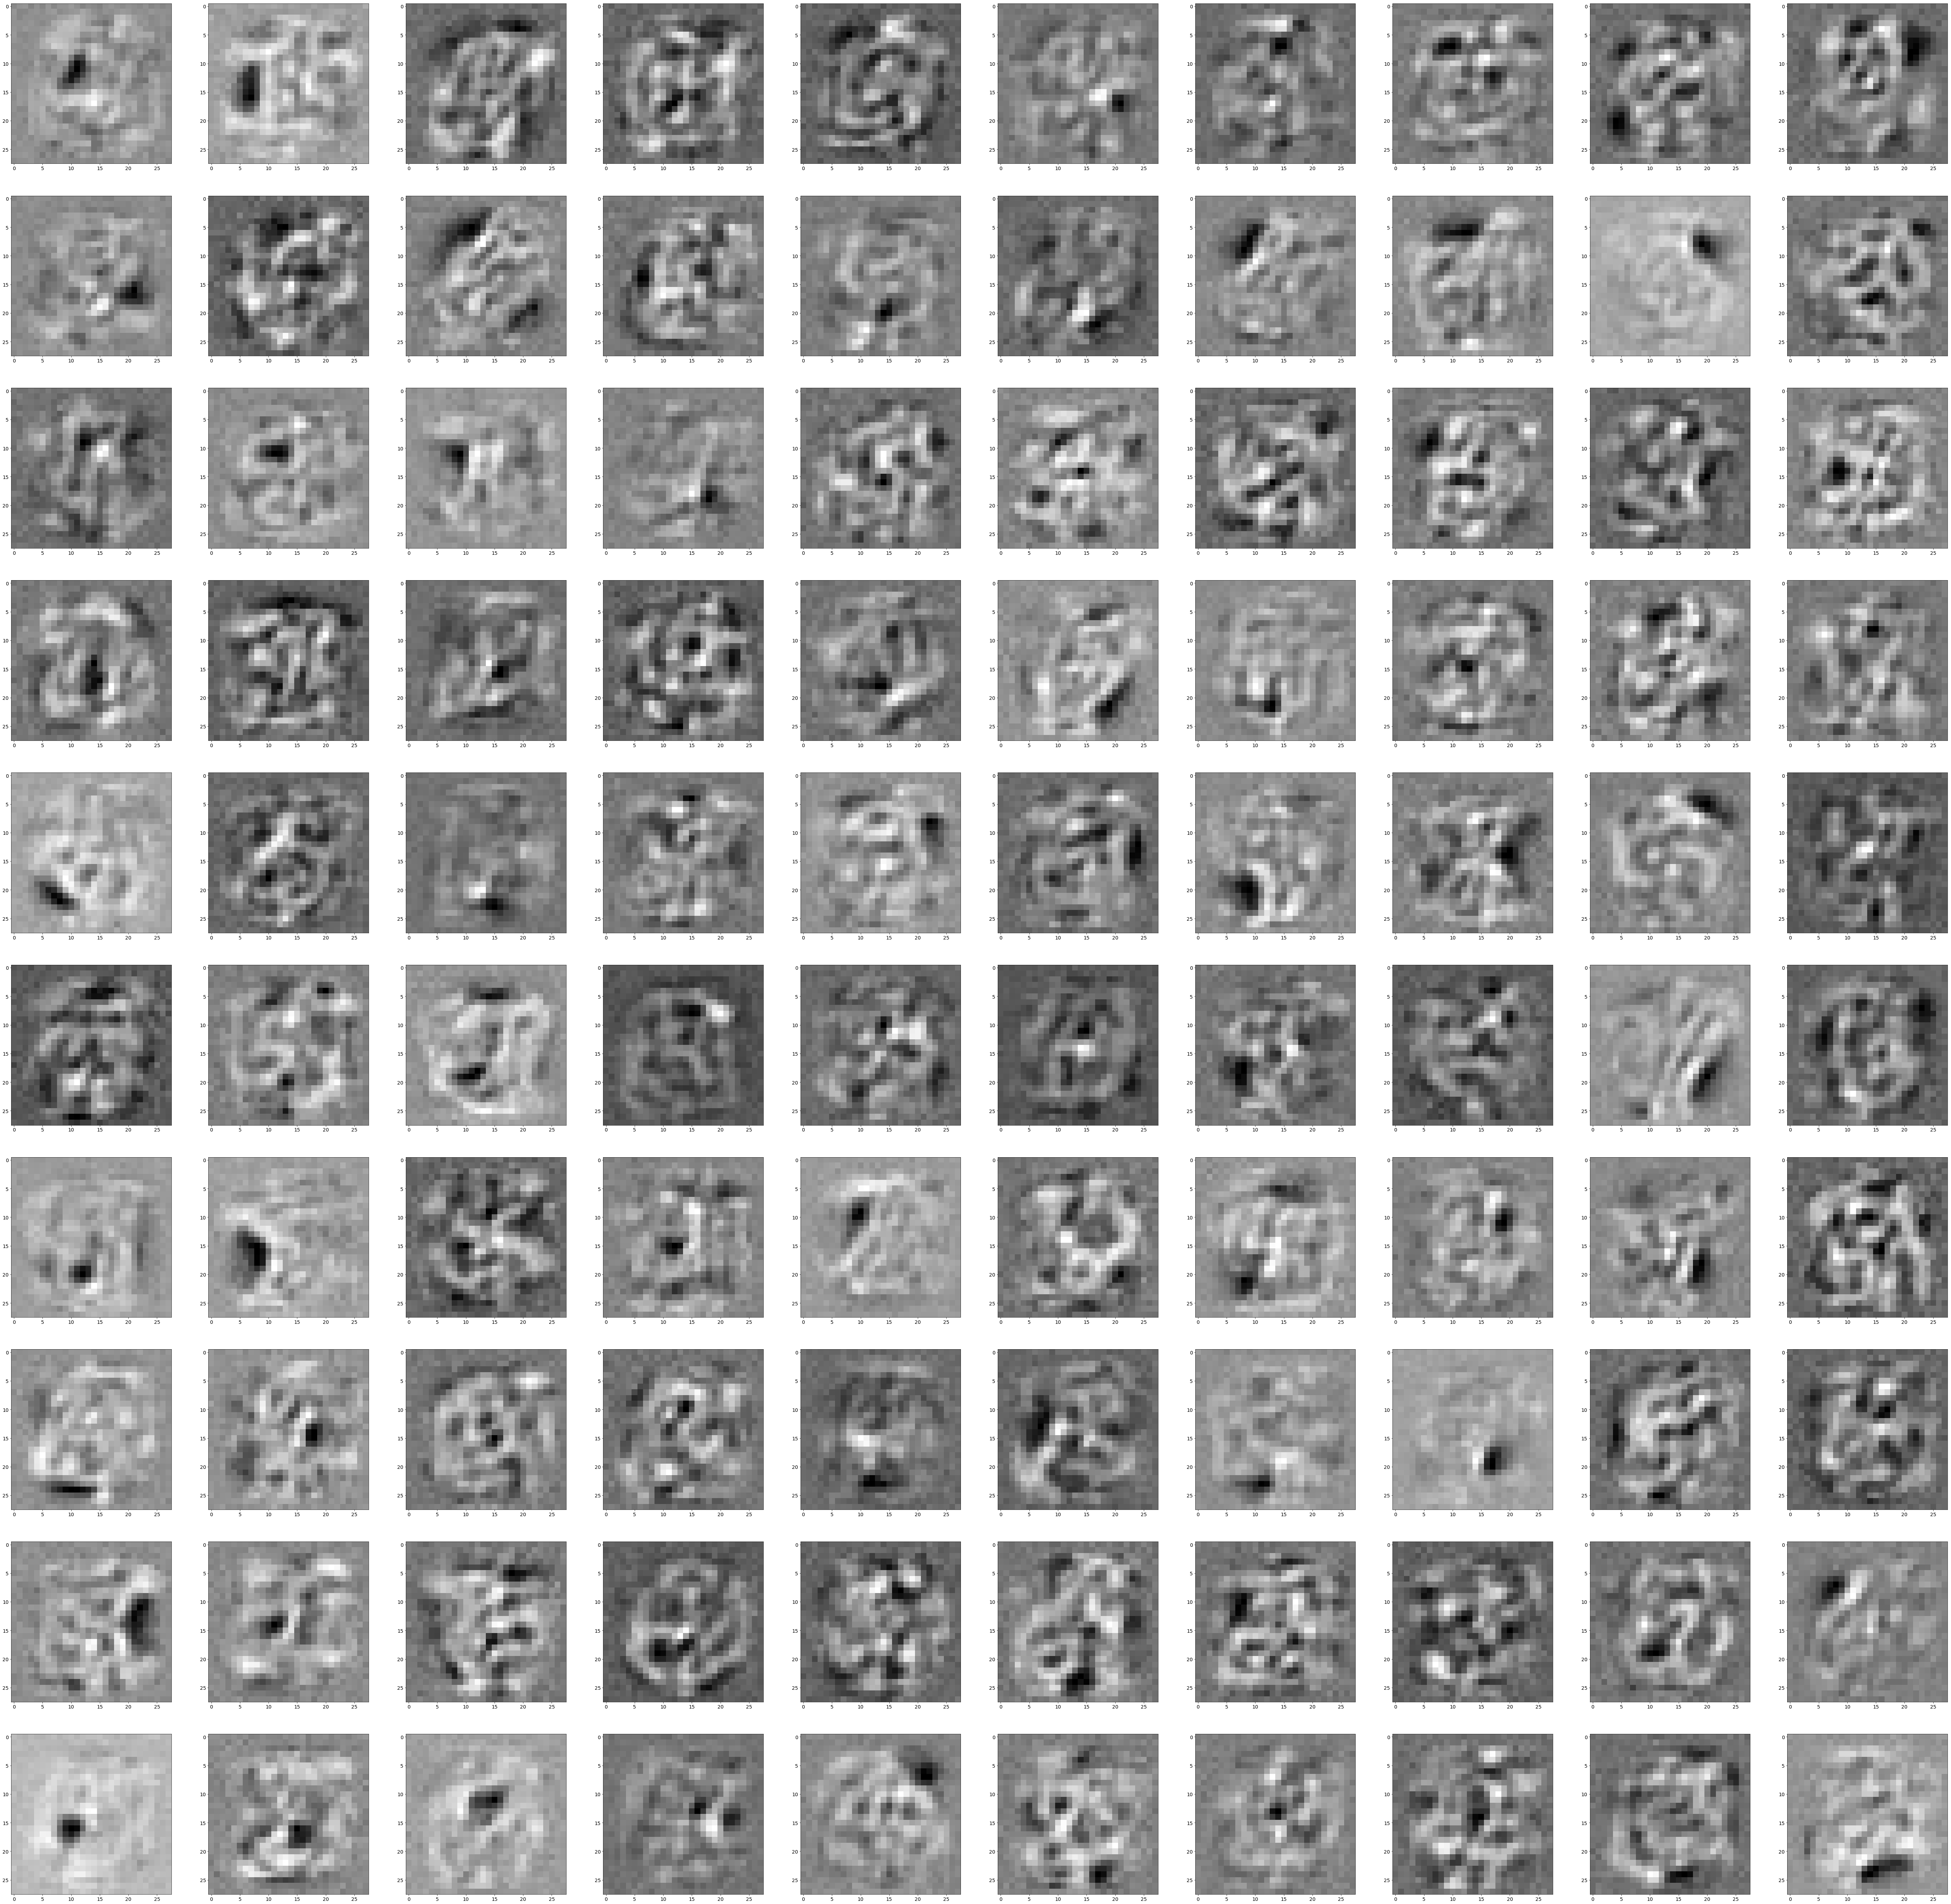

In [91]:
visualize_100_weights(np.asarray(hdf1['w']))

## ### Note: The unsupervised pre-training of a NN using the Denoising Autoencoder's weights is done at the very end after part (g) 

## g) Playing with different number of hidden units

In [ ]:
h_counts = [50, 200, 500]
max_epochs = 1000
for i in range(len(h_counts)):
    # RBM
    print('-----------------RBM, %s--------------' % (h_counts[i]))
    start_time = time.clock()
    rbm1 = rbm.RBM(
               h_count=h_counts[i], 
               v_count=x_train.shape[1], 
               random_seed=2017, 
               results_file=rbm_results_path + 'rbm_g_' + str(h_counts[i]) + '.hdf5')

    rbm1.train(trn_data=x_train, 
           vldn_data=x_valid, 
           mini_batch_size=32, 
           cd_k=1, 
           lrn_rate=0.1, 
           max_epochs=max_epochs,
           vldn_error_stopping_threshold=0.1, 
           vldn_error_checking_window=10, 
           suppress_output=False)

    end_time = time.clock()
    print('Time taken for RBM with h_count = %s  = %s' % (h_counts[i], (end_time - start_time)/60.0))

    # Autoencoder
    print('-----------------AE, %s--------------'% (h_counts[i]))
    start_time = time.clock()
    ae = autoencoder.AE(h_count=h_counts[i], 
                        v_count=x_train.shape[1], 
                        random_seed=2017, 
                        results_file=ae_results_path + 'ae_g_' + str(h_counts[i]) + '.hdf5')


    ae.train(trn_data=x_train, 
         vldn_data=x_valid, 
         mini_batch_size=32, 
         lrn_rate=0.001, 
         max_epochs=max_epochs,
         dropout=0, 
         vldn_error_stopping_threshold=0.05, 
         vldn_error_checking_window=10, 
         suppress_output=False)

    end_time = time.clock()
    print('Time taken for AE with h_count = %s  = %s' % (h_counts[i], (end_time - start_time)/60.0))


    # DA with dropout 0.1
    print('-----------------DAE, %s--------------'% (h_counts[i]))
    start_time = time.clock()
    da = autoencoder.AE(h_count=h_counts[i], 
                        v_count=x_train.shape[1], 
                        random_seed=2017, 
                        results_file=ae_results_path + 'da_g_' + str(h_counts[i]) + '.hdf5')


    da.train(trn_data=x_train, 
         vldn_data=x_valid, 
         mini_batch_size=32, 
         lrn_rate=0.001, 
         dropout=0.1,
         max_epochs=max_epochs,
         vldn_error_stopping_threshold=0.05, 
         vldn_error_checking_window=10, 
         suppress_output=False)

    end_time = time.clock()
    print('Time taken for DA with h_count = %s  = %s' % (h_counts[i], (end_time - start_time)/60.0))

### Different Hidden Units for Autoencoder

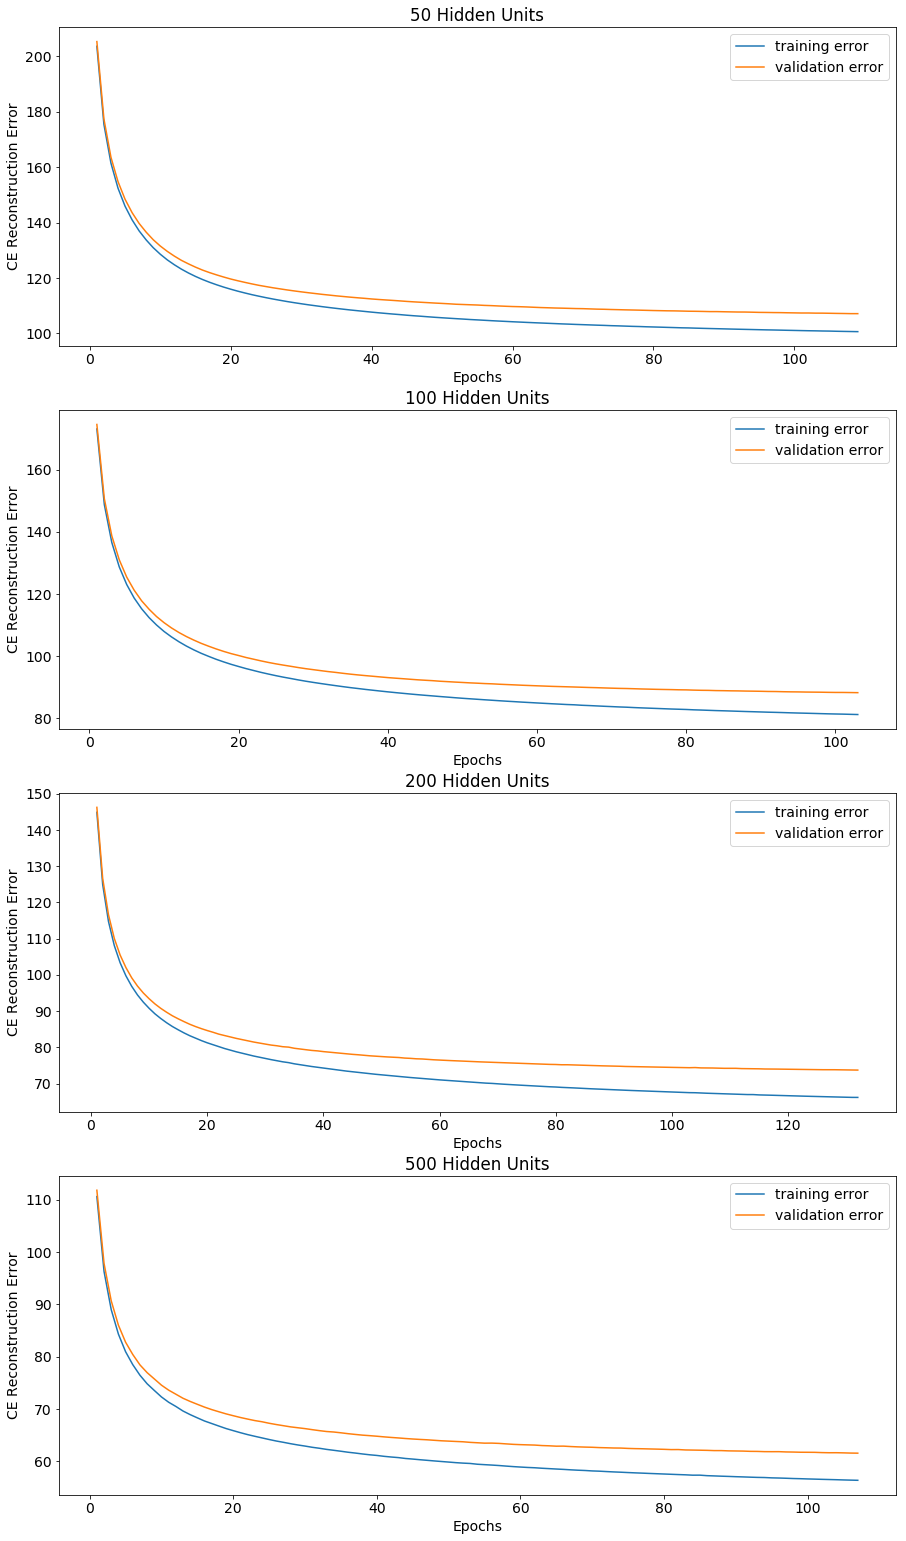

In [76]:
hidden_units = [50, 100, 200, 500]
ae_results = {50: pd.HDFStore(ae_results_path + 'ae_g_50.hdf5'),
           100 : pd.HDFStore(ae_results_path + 'ae1.hdf5'),
           200 : pd.HDFStore(ae_results_path + 'ae_g_200.hdf5'),
           500 : pd.HDFStore(ae_results_path + 'ae_g_500.hdf5')}

# Getting the training and validation errors
ae_trn_errors = {}
ae_vldn_errors = {}
for key in ae_results.keys():
    ae_trn_errors[key] = ae_results[key]['trn_ce_recon_err']
    ae_vldn_errors[key] = ae_results[key]['vldn_ce_recon_err']

# Plotting the graph
plot_varying_hidden_units(trn_errors=ae_trn_errors, vldn_errors=ae_vldn_errors, hidden_units=hidden_units)

### Effect of varying Hidden Units on an Autoencoder:
- Increasing hidden units causes the losses to fall further within the same number of epochs. 500 hidden units see the lowest validation and training losses (around 65 and 60 respectively). This is probably due the fact the more hidden units can better approximate the input space and therefore can capture more subtle variations in the input.

### Different Hidden Units for Denoising Autoencoder (dropout = 0.1)

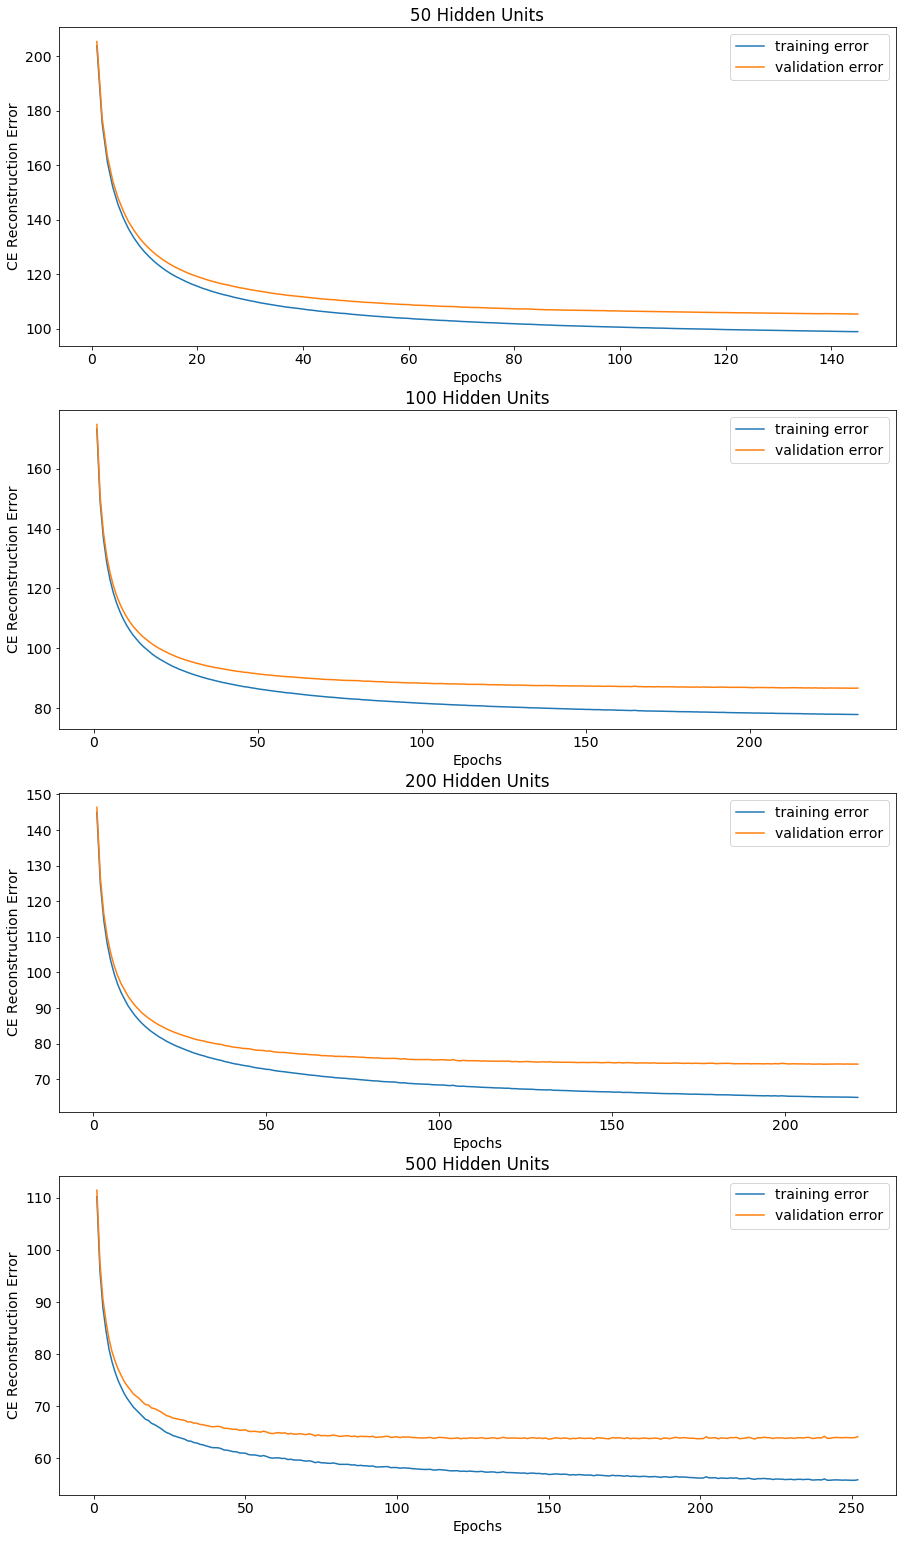

In [78]:
hidden_units = [50, 100, 200, 500]
da_results = {50: pd.HDFStore(ae_results_path + 'da_g_50.hdf5'),
           100 : pd.HDFStore(ae_results_path + 'ae2.hdf5'),
           200 : pd.HDFStore(ae_results_path + 'da_g_200.hdf5'),
           500 : pd.HDFStore(ae_results_path + 'da_g_500.hdf5')}

# Getting the training and validation errors
da_trn_errors = {}
da_vldn_errors = {}
for key in da_results.keys():
    da_trn_errors[key] = da_results[key]['trn_ce_recon_err']
    da_vldn_errors[key] = da_results[key]['vldn_ce_recon_err']

plot_varying_hidden_units(trn_errors=da_trn_errors, vldn_errors=da_vldn_errors, hidden_units=hidden_units)

### Effect of varying Hidden Units on an Denoising Autoencoder (dropout = 0.1):
- Increasing hidden units causes the losses to fall further within the same number of epochs. 500 hidden units see the lowest validation and training losses (around 65 and 60 respectively). This is probably due the fact the more hidden units can better approximate the input space and therefore can capture more subtle variations in the input.

### Different Hidden Units for RBM

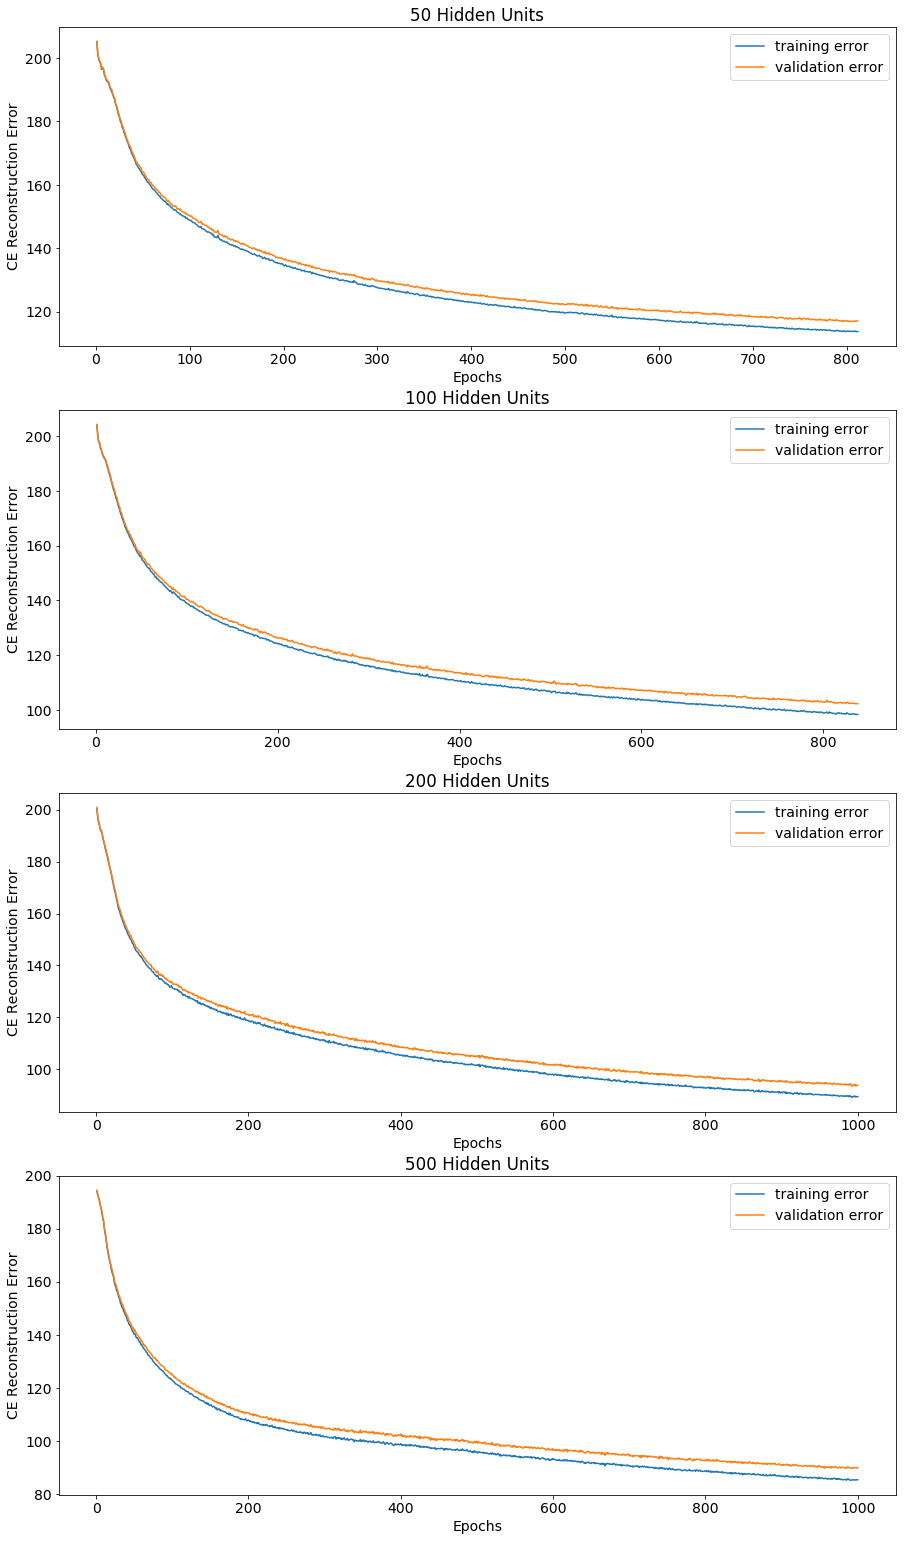

In [79]:
hidden_units = [50, 100, 200, 500]
rbm_results = {50: pd.HDFStore(rbm_results_path + 'rbm_g_50.hdf5'),
           100 : pd.HDFStore(rbm_results_path + 'rbm1.hdf5'),
           200 : pd.HDFStore(rbm_results_path + 'rbm_g_200.hdf5'),
           500 : pd.HDFStore(rbm_results_path + 'rbm_g_500.hdf5')}

# Getting the training and validation errors
rbm_trn_errors = {}
rbm_vldn_errors = {}
for key in rbm_results.keys():
    rbm_trn_errors[key] = rbm_results[key]['trn_ce_recon_err']
    rbm_vldn_errors[key] = rbm_results[key]['vldn_ce_recon_err']

# Plotting the graph
plot_varying_hidden_units(trn_errors=rbm_trn_errors, vldn_errors=rbm_vldn_errors, hidden_units=hidden_units)

### Generalization effect of varying hidden units:
### - Autoencoder with 500 hidden units

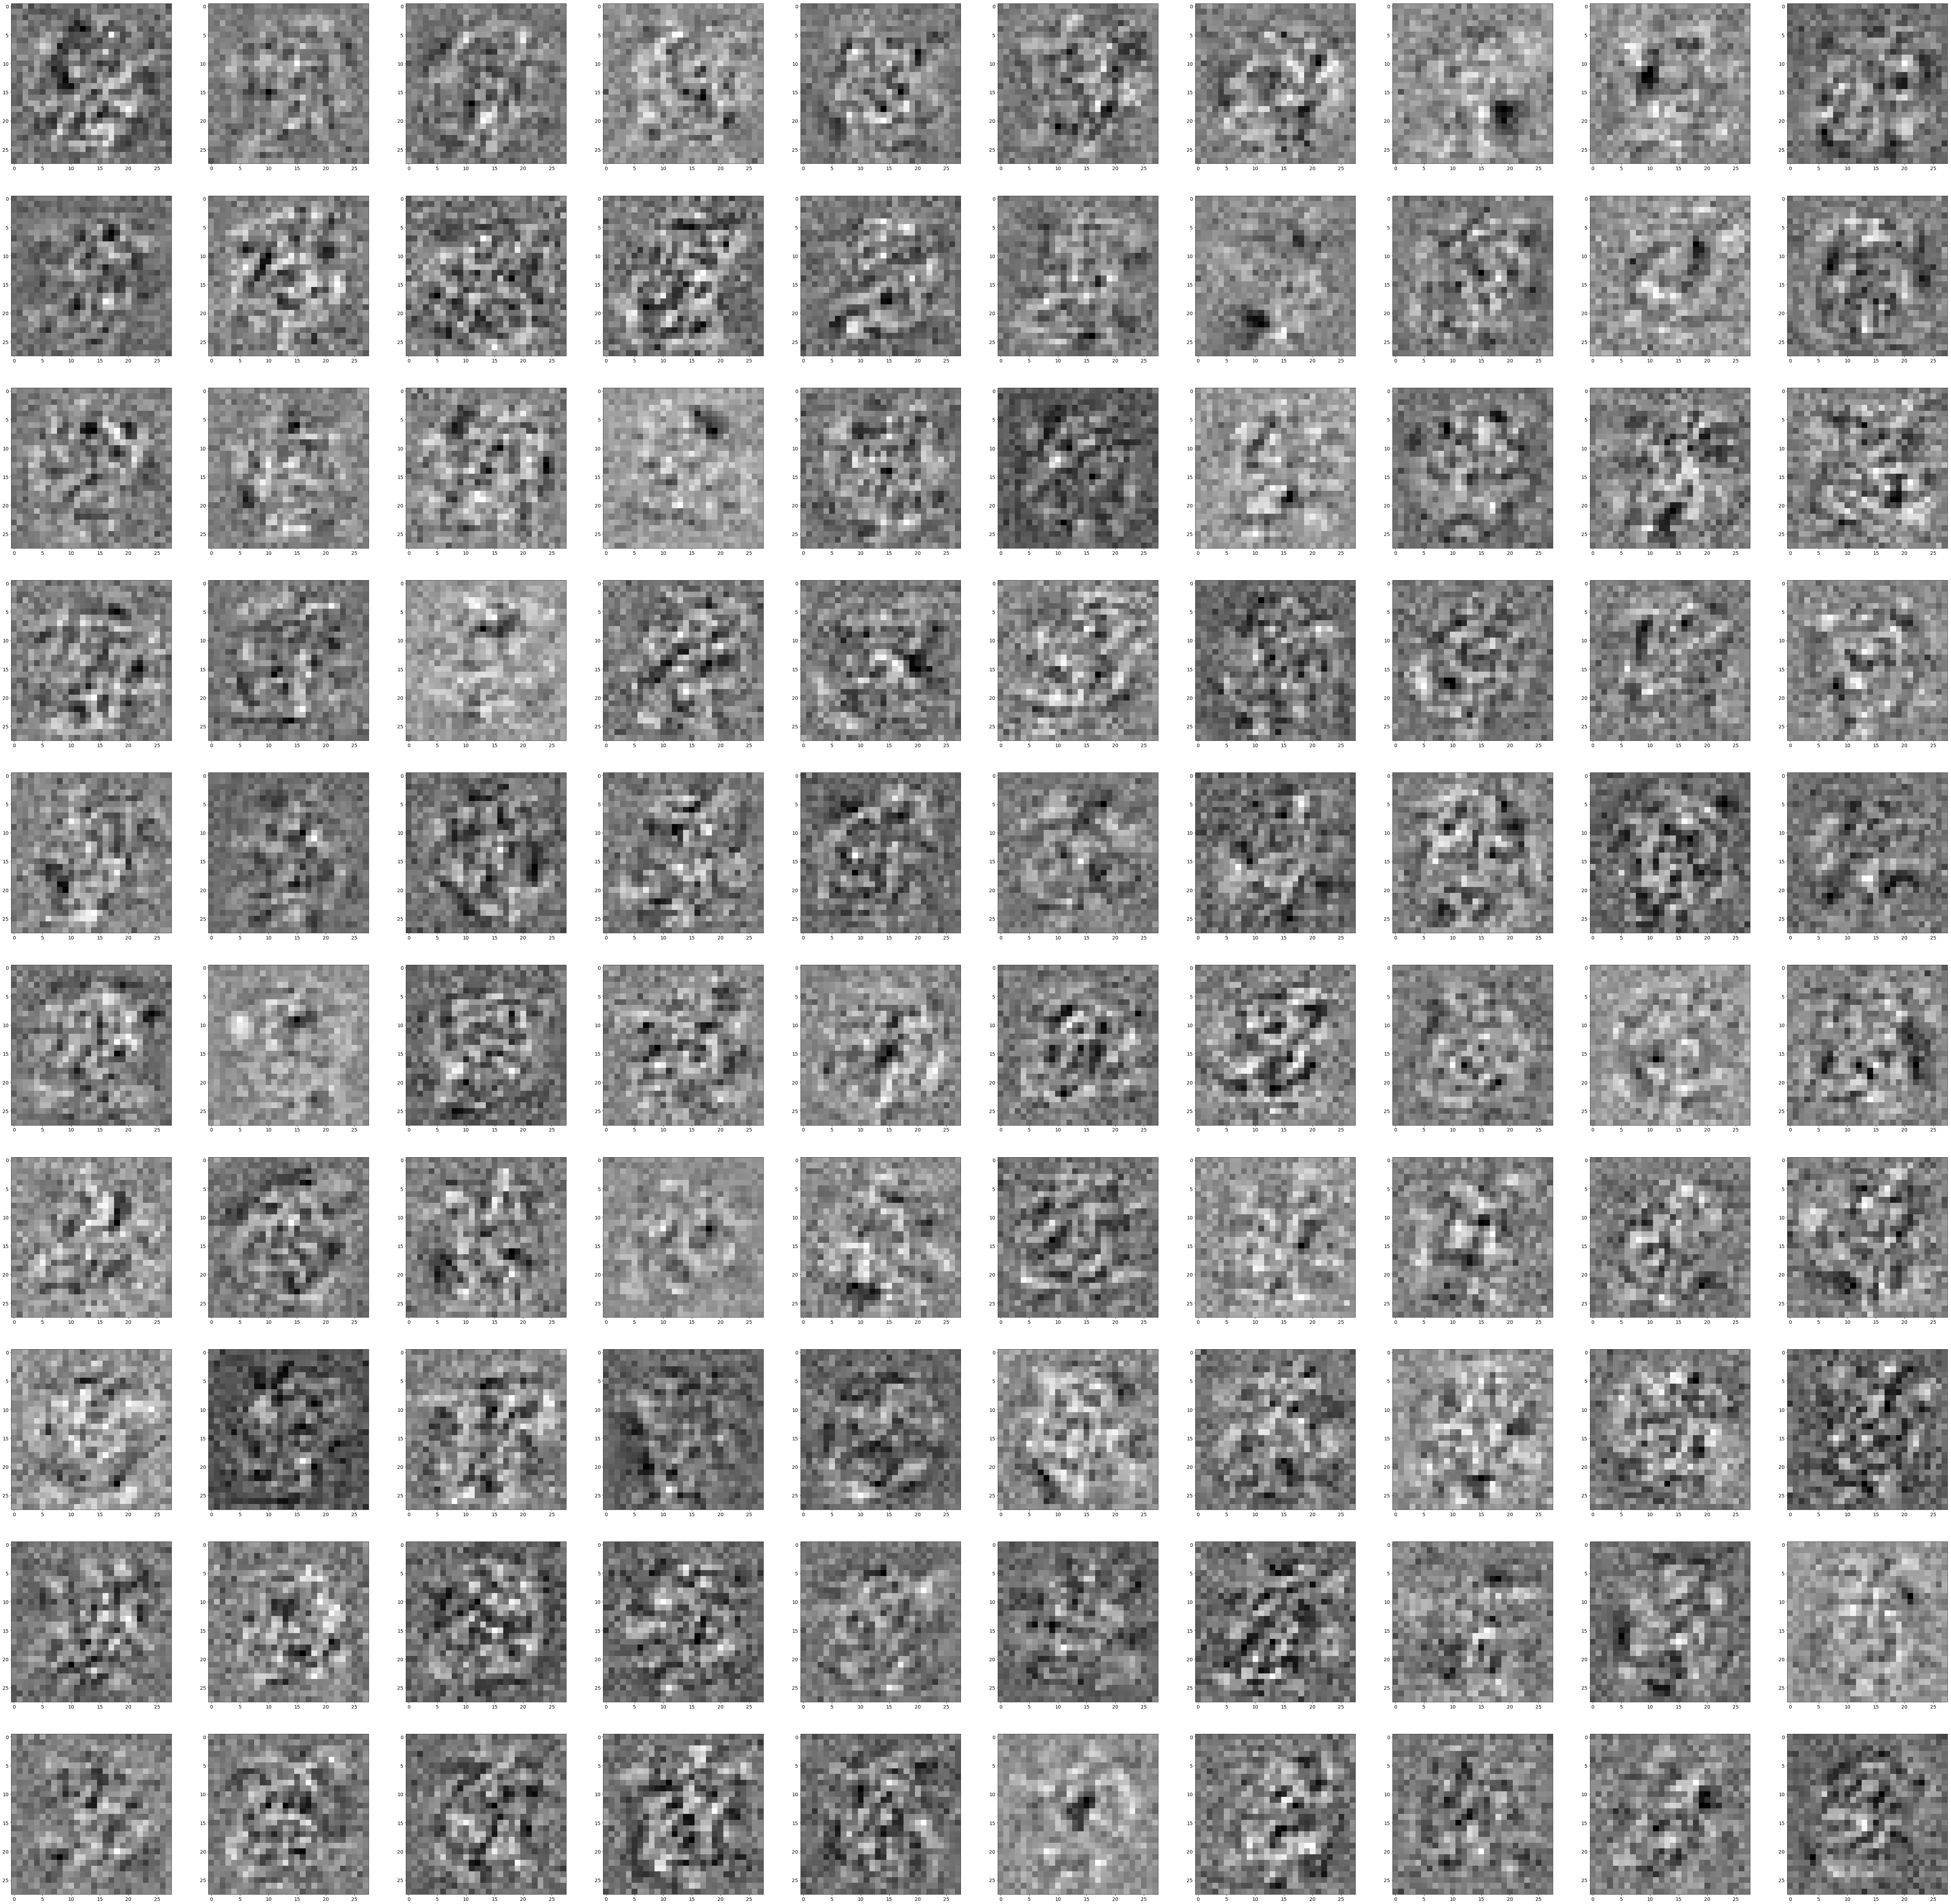

In [117]:
hdf = pd.HDFStore(ae_results_path + 'ae_g_500.hdf5')
w = np.asarray(hdf['w'])
visualize_100_weights(w)

### - Denoising Autoencoder with 500 hidden units

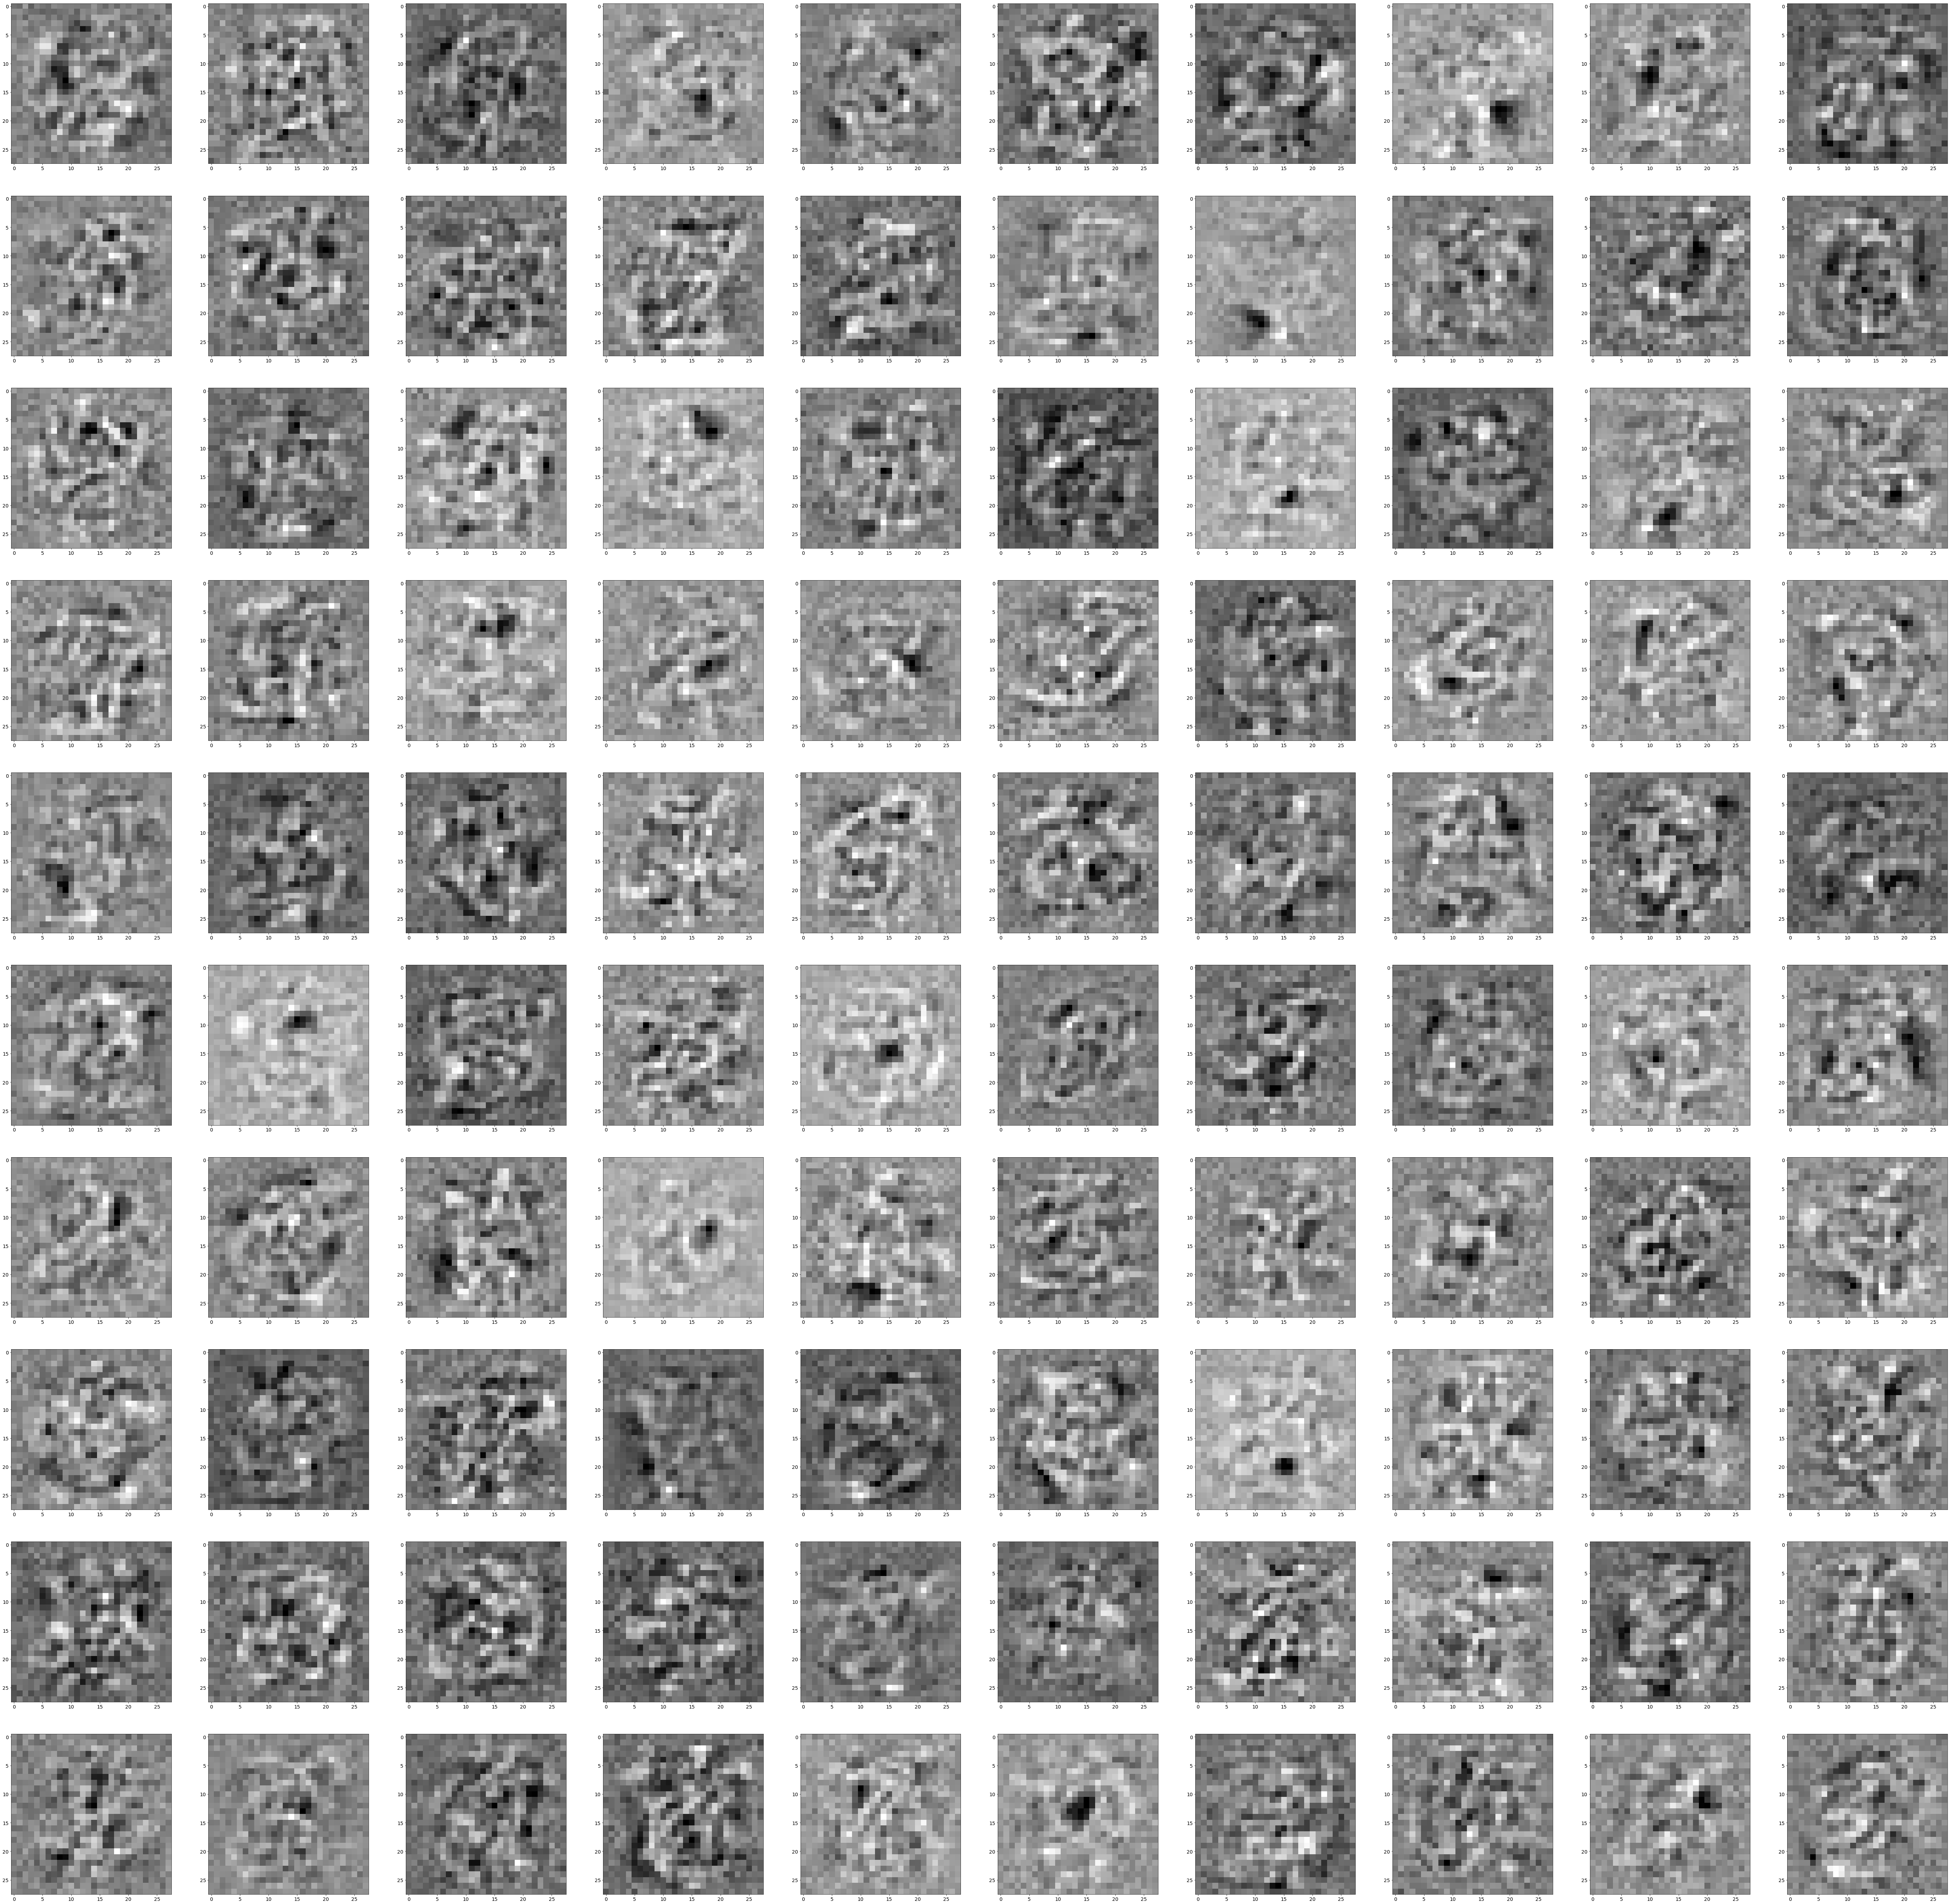

In [118]:
hdf = pd.HDFStore(ae_results_path + 'da_g_500.hdf5')
w = np.asarray(hdf['w'])
visualize_100_weights(w)

### - RBM with 500 hidden units

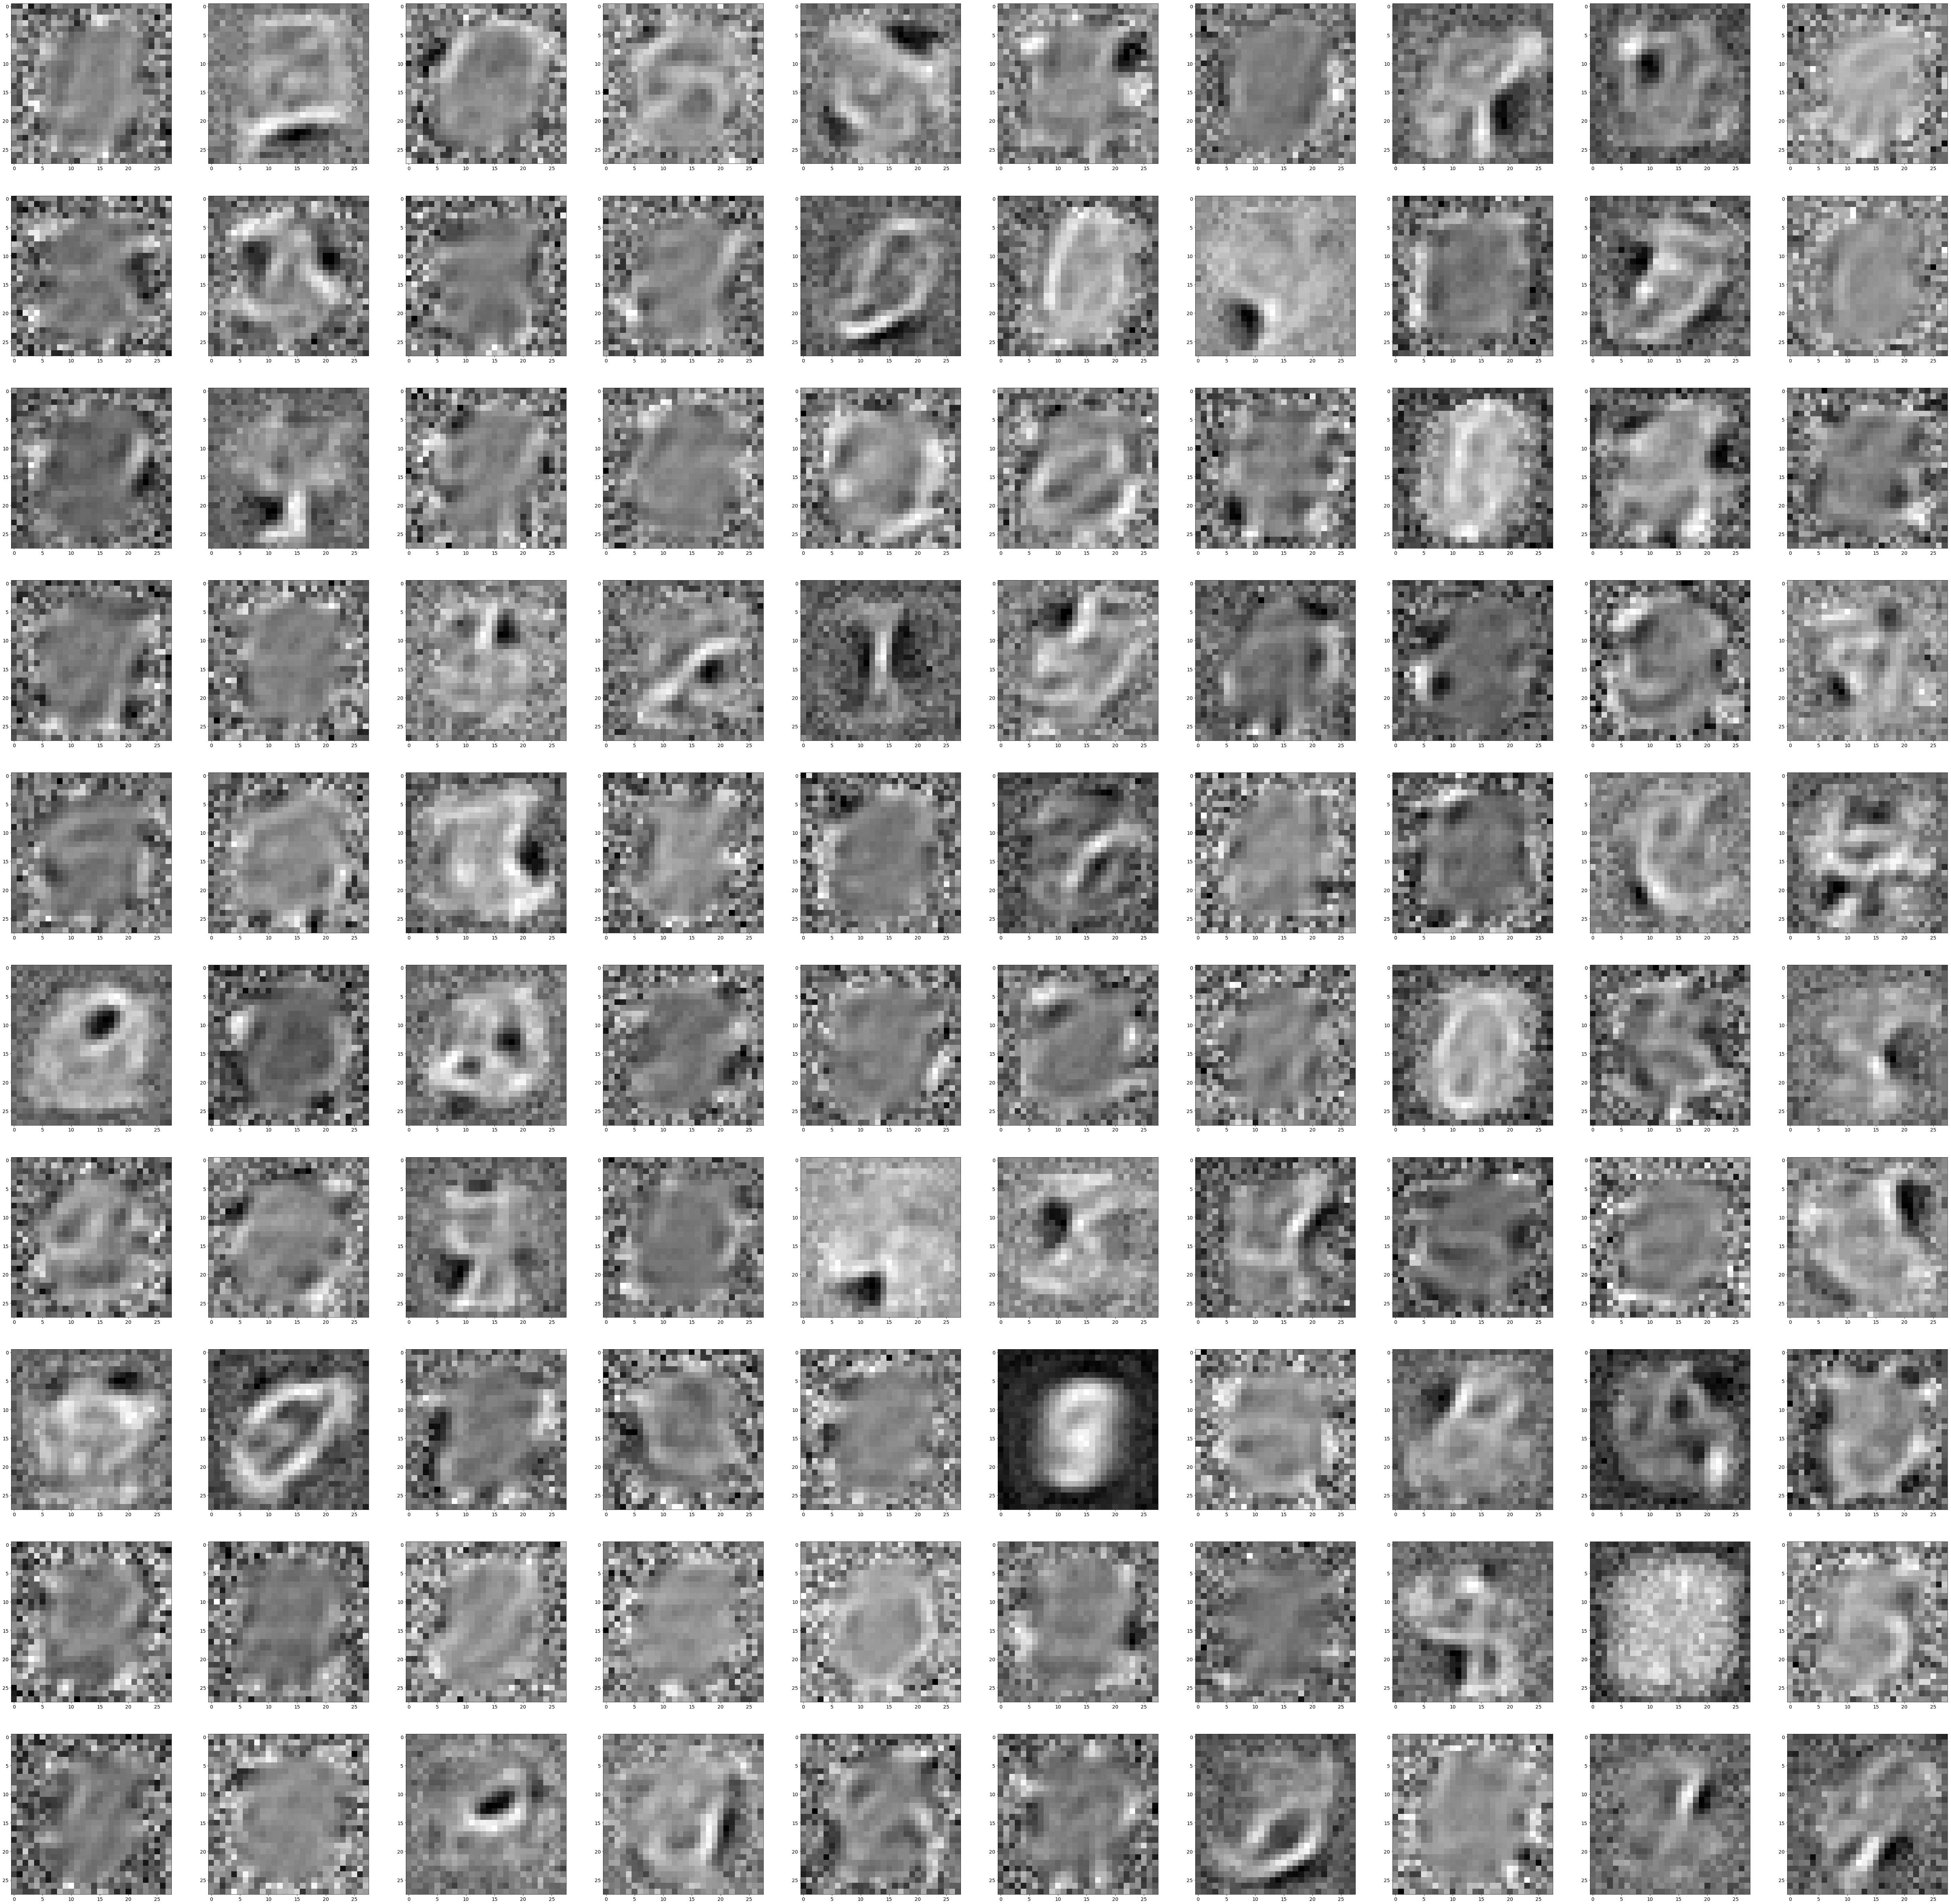

In [119]:
hdf = pd.HDFStore(rbm_results_path + 'rbm_g_500.hdf5')
w = np.asarray(hdf['w'])
visualize_100_weights(w)

## Unsupervised Pretraining - Answers for parts d) , e), f)
This part involves training a single hidden layer neural network with the weights learned from training:
- RBM from part (a)
- Autoencoder from part (e)
- Denoising AE from part (f) 
and comparing them with training a nn initalized with random weights.

The models were trained using:
- mini batch size = 32
- learning rate = 0.1
- momentum = 0
- no weight decay
- early stopping with a patience window of 15 epochs

In [8]:
hidden_layers_dict = {1: {"UNITS": 100, "ACTIVATION_FUNCTION": "SIGMOID"}}

# Random weights
b = math.sqrt(6)/math.sqrt(100 + 784)
w = np.random.uniform(-b, b, (784, 100))
random_w_results = nc.run_nn(batch_size=32,
                        max_epochs=500,
                        learning_rate=0.1,
                        hidden_layers_info=hidden_layers_dict,
                        momentum=0,
                        reg_decay=0,
                        early_stopping_patience_limit=15,
                        seed=2017,
                        pickle_file_destination=rbm_results_path + 'random_w_nn.pickle',
                        w=w, 
                        suppress_output=True)

# RBM weights 
w = pd.HDFStore(rbm_results_path +'rbm1.hdf5')['w']
rbm_w_results = nc.run_nn(batch_size=32,
                        max_epochs=500,
                        learning_rate=0.1,
                        hidden_layers_info=hidden_layers_dict,
                        momentum=0,
                        reg_decay=0,
                        early_stopping_patience_limit=15,
                        seed=2017,
                        pickle_file_destination=rbm_results_path + 'rbm_w_nn.pickle',
                        w=w,
                        suppress_output=True)

# Autoencoder
w_ae = pd.HDFStore(ae_results_path +'ae1.hdf5')['w']
ae_w_results = nc.run_nn(batch_size=32,
                        max_epochs=500,
                        learning_rate=0.1,
                        hidden_layers_info=hidden_layers_dict,
                        momentum=0,
                        reg_decay=0,
                        early_stopping_patience_limit=15,
                        seed=2017,
                        pickle_file_destination=ae_results_path + 'ae_w_nn.pickle',
                        w=w_ae, suppress_output=True)

# Denoising AE
w_da = pd.HDFStore(ae_results_path +'ae2.hdf5')['w']
da_w_results = nc.run_nn(batch_size=32,
                        max_epochs=500,
                        learning_rate=0.1,
                        hidden_layers_info=hidden_layers_dict,
                        momentum=0,
                        reg_decay=0,
                        early_stopping_patience_limit=15,
                        seed=2017,
                        pickle_file_destination=ae_results_path + 'da_w_nn.pickle',
                        w=w_da, suppress_output=True)


### Comparing convergence of the neural networks

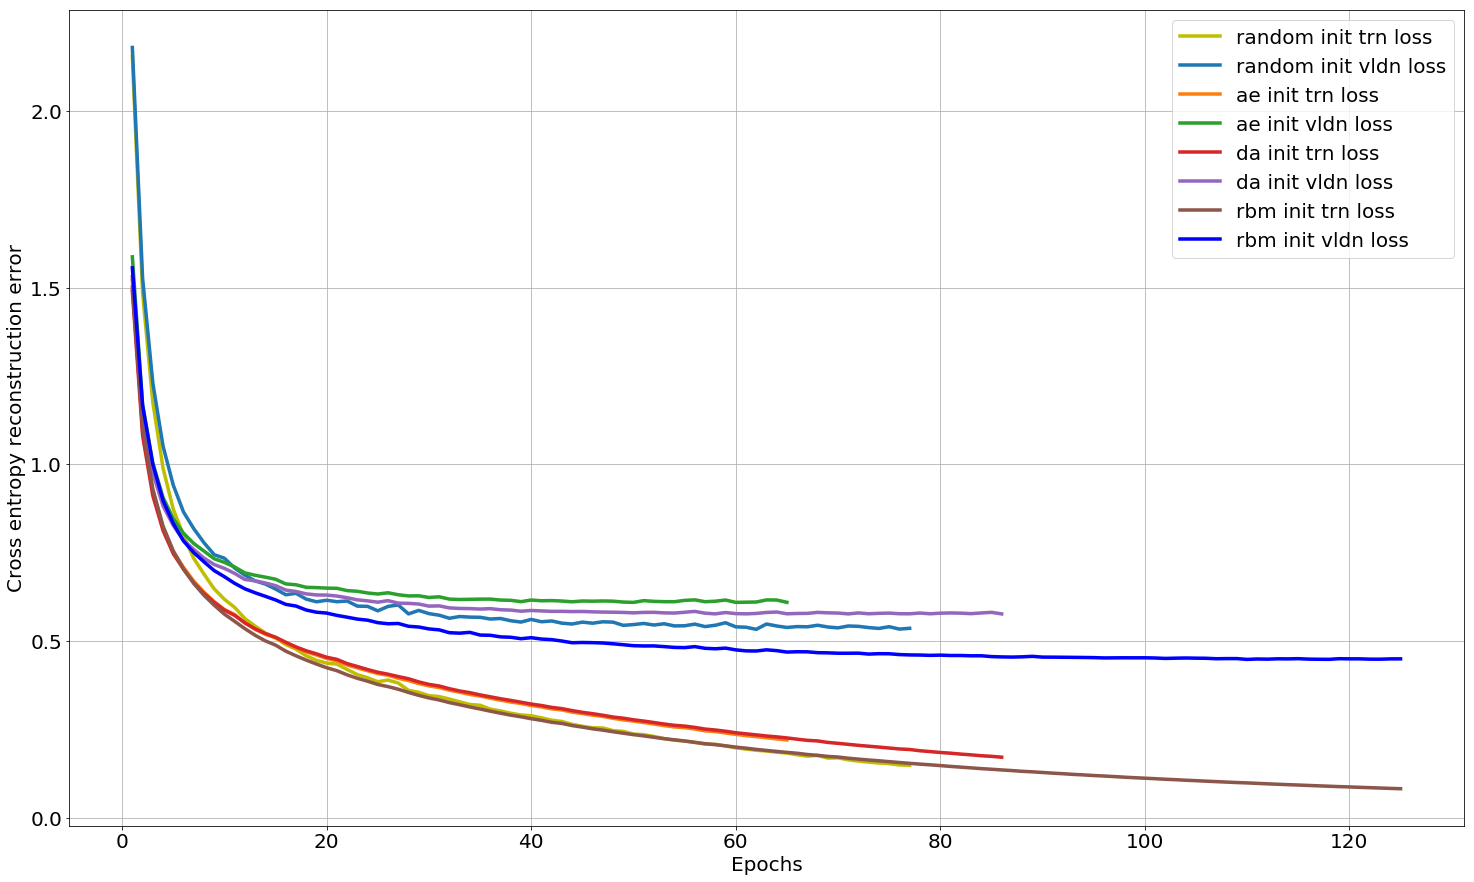

In [59]:
random_epochs = random_w_results['epochs']
random_trn_loss = random_w_results['avg_trn_loss']
random_vldn_loss = random_w_results['avg_vdn_loss']
random_test_acc = random_w_results['test_acc']

rbm_epochs = rbm_w_results['epochs']
rbm_trn_loss = rbm_w_results['avg_trn_loss']
rbm_vldn_loss = rbm_w_results['avg_vdn_loss']
rbm_test_acc = rbm_w_results['test_acc']

ae_epochs = ae_w_results['epochs']
ae_trn_loss = ae_w_results['avg_trn_loss']
ae_vldn_loss = ae_w_results['avg_vdn_loss']
ae_test_acc = ae_w_results['test_acc']

da_epochs = da_w_results['epochs']
da_trn_loss = da_w_results['avg_trn_loss']
da_vldn_loss = da_w_results['avg_vdn_loss']
da_test_acc = da_w_results['test_acc']

matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(25, 15))

plt.plot(random_epochs,random_trn_loss, label="random init trn loss", linewidth=3.5, color='y')
plt.plot(random_epochs,random_vldn_loss, label="random init vldn loss", linewidth=3.5)
plt.plot(ae_epochs,ae_trn_loss, label="ae init trn loss", linewidth=3.5)
plt.plot(ae_epochs,ae_vldn_loss, label="ae init vldn loss", linewidth=3.5)
plt.plot(da_epochs,da_trn_loss, label="da init trn loss", linewidth=3.5)
plt.plot(da_epochs,da_vldn_loss, label="da init vldn loss", linewidth=3.5)
plt.plot(rbm_epochs,rbm_trn_loss, label="rbm init trn loss", linewidth=3.5)
plt.plot(rbm_epochs,rbm_vldn_loss, label="rbm init vldn loss", linewidth=3.5, color='b')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Cross entropy reconstruction error')
plt.legend()
plt.show()

### Observations:
- Unsupervised pre-training does ensure that the neural network starts at lower training and validation accuracies than in the case where the weights of the hidden layer are randomly intialized
- NNs pretrained with Autoencoder weights take lesser time to converge than those pretrained with RBM weights.
- Pretraining using RBM weights causes the network to take longer to converge but the final training and validation losses achieved are much lower than those of AE and DA.

### Comparing test accuracies
The final test accuracies are:
- Random Weight Init: 89.33 %
- RBM: 91.03 %
- Autoencoder : 87.57%
- Denoising Autoencoder : 87.17 %